# 영업 성공 여부 분류 경진대회

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install autogluon

In [ ]:
# pip install --upgrade scikit-learn

In [ ]:
# !pip install --upgrade imbalanced-learn

## 1. 데이터 확인

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

import lightgbm as lgb

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Taeho/LGAimers/train.csv') # 학습용 데이터
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Taeho/LGAimers/submission.csv') # 테스트 데이터(제출파일의 데이터)

In [4]:
#Seed 고정
import random
import os
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(69)

## 2.1 데이터 전처리 - 데이터 정제

In [5]:
## 정제 전
print(df_train.shape, df_test.shape)

(59299, 29) (5271, 30)


In [6]:
## 복제된 행 제거
df_train.drop_duplicates(inplace=True)

# 무조건 converted하면서 test에 없는 회사인 25096은 삭제
del_cus_id=[25096]
df_train=df_train[~df_train["customer_idx"].isin(del_cus_id)]

print(df_train.shape, df_test.shape)

(53376, 29) (5271, 30)


In [7]:
## 복제된 행 제거, 25096 제거
print(df_train.shape, df_test.shape)

(53376, 29) (5271, 30)


### 결측치 채우기전 파생변수

#### 파생변수 1. bn_submit: band_submit에서 customer_position이랑 expected timeline 작성한 경우 제거


In [8]:
import pandas as pd

# df_train과 df_test를 합친다
df_all = pd.concat([df_train, df_test])
df_all['bn_submit'] = 0

# customer_position이 'none'이 아닌 경우를 체크
condition_position = df_all['customer_position'] != 'none'

df_all["customer_position"]=df_all['customer_position'].replace('none', np.nan)

# expected_timeline이 null이 아닌 경우를 체크
condition_timeline = pd.notnull(df_all['expected_timeline'])

# 조건에 따라 tt 값을 계산
tt = condition_position.astype(int) + condition_timeline.astype(int)

# bn_submit 컬럼 업데이트
df_all['bn_submit'] = df_all['bant_submit'] - (tt / 4)

df_all['customer_position'].replace('none', np.nan)

# df_train과 df_test로 다시 분리
df_train = df_all.iloc[:len(df_train)]
df_test = df_all.iloc[len(df_train):]

df_train = df_train.drop('id', axis=1)

In [9]:
print(df_train.shape, df_test.shape)

(53376, 30) (5271, 31)


#### 파생변수 2. num_missing: 각 행별로 결측치의 개수 count

In [10]:
df_all = pd.concat([df_train, df_test])
df_all['num_missing'] = df_all.isnull().sum(axis=1) - 1

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]
df_train = df_train.drop('id', axis=1)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53376 entries, 0 to 59298
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              53376 non-null  float64
 1   customer_country         52488 non-null  object 
 2   business_unit            53376 non-null  object 
 3   com_reg_ver_win_rate     14072 non-null  float64
 4   customer_idx             53376 non-null  int64  
 5   customer_type            14422 non-null  object 
 6   enterprise               53376 non-null  object 
 7   historical_existing_cnt  12297 non-null  float64
 8   id_strategic_ver         3328 non-null   float64
 9   it_strategic_ver         1108 non-null   float64
 10  idit_strategic_ver       4436 non-null   float64
 11  customer_job             37123 non-null  object 
 12  lead_desc_length         53376 non-null  int64  
 13  inquiry_type             52562 non-null  object 
 14  product_category      

### 2.1.1 오타 제어(customer_country)

In [12]:
## 2. customer_country 오타 제어 함수
def extract_country_name(x):
    if pd.isnull(x):
        return np.nan
    else:
        idx=-1
        a = x.split("/")[idx].strip()
        while a=='':
            idx-=1
            if idx == -4 :
                return 'others'
            a = x.split("/")[idx].strip()
        if idx != -1:
            if a in ['Richmond Hill', 'Vancouver', 'Pickering', 'Winnipeg']:
                return 'Canada'
            elif a in ['ROURKELA', 'Guna mp', 'MADURAI', 'KOLKATA', 'Ahmedabad', 'Madurai'
                       'Mathura', 'Delhi', 'Solan', 'Bengaluru', 'Kanchipuram', 'Erode',
                       'NEARAMBEDKAR HOSPET', 'Bhubaneswar', 'LATEHAR', 'Malur', 'Ackerman',
                       'Faridabad', 'Vasal', 'Ballia', 'Ludhiana', 'Rajkot']:
                return 'India'
            elif a in ['Bergdietikon']:
                return 'Switzerland'
            elif a in ['Lagos, Nigeria', 'Ikoyi', 'Abuja', 'Windhoek']:
                return 'Nigeria'
            elif a in ['Monrovia']:
                return 'Liberia'
            elif a in ['Malvern', 'Cambridge', 'Danbury', 'Dundee', 'Boulder', 'Liverpool', 'Winston']:
                return 'United Kingdom'
            elif a in ['San Jose', 'Bulacan', 'Makati City', 'Manila', 'Cebu', 'Pasig',
                       'CALOOCAN CITY', 'dasmarinas city', 'Mandaluyong City','Angeles' 'makati', 'Angeles City',
                        'Bataan', 'TAYTAY', 'Las Piñas - Muntinlupa', 'Quezon City' ,'Valenzuela City',
                        '314 G. Araneta Ave., Quezon City', 'PASIG CITY', 'Manila', 'San Fernando City, La Union', 'Valenzuela'
                        'CAINTA', 'Quezon City', 'Camarines Sur', 'Mandaluyong', 'San Juan city', 'Qc', 'Meycauayan City, Bulacan',
                        'Parañaque','Rizal', 'Makati city', 'CITY OF IMUS', 'laGrange', 'Sanford', 'Chilhowie', 'Chesterfield', 'Amherst',
                        'Paranaque', 'Cavite', 'CITY OF MARIKINA', 'Bocaue, Bukacan, Philippines']:
                return 'Philippines'

            elif a in ['Atlanta', 'Tbilisi'] :
                return "Georgia"
            elif a in ['Oslo']:
                return 'Norway'
            elif a in ['Arroyo Hondo Viejo'] :
                return 'Dominican Republic'
            elif a in ['Midrand']:
                return 'South Africa'
            elif a in ['Olsztyn', 'Przemysłowa 4, 37-450 Stalowa Wola']:
                return "Poland"
            elif a in ['San Juan']:
                return 'Puerto Rico'
            elif a in ['Berlin', 'Weikersheim', 'Herdwangen-Schönach']:
                return 'Germany'
            elif a in ['Nassau']:
                return 'Bahamas'
            elif a in ['Sapphire', "Mission Hills", 'North Haven', 'Melbourne']:
                return 'Australia'
            elif a in ['Madrid, Spain', 'Madrid', 'Barrio Viejo De Callosa De Segura']:
                return 'Spain'
            elif a in ['Kuwait city'] :
                return 'Kuwait'
            elif a in ['Esch-sur-Alzette']:
                return 'Luxembourg'
            elif a in ['Tashkent']:
                return 'Uzbekistan'
            elif a in ['Taipei city']:
                return 'Taiwan'
            elif a in ['Tokyo']:
                return 'Japan'
            elif a in ['Thai Binh', 'Hai Duong']:
                return 'Vietnam'
            elif a in ['Buengkum']:
                return 'Thailand'
            elif a in ['Gardabaer']:
                return 'Iceland'
            elif a in ['Riyadh', "Makkah", 'Riyadh'] :
                return 'Saudi Arabia'
            elif a in ['Králův Dvůr Levín']:
                return 'Czech Republic'
            elif a in ['Cairo', 'Bloch']:
                return 'Egypt'
            elif a in ['Maseru']:
                return 'Lesotho'
            elif a in ['Colombo 03']:
                return 'Sri Lanka'
            elif a in ["Tirana"]:
                return 'Albania'
            elif a in ['70']:
                return 'others'
            elif a in ['Jakarta'] :
                return 'Indonesia'
            elif a in ['Paramaribo'] :
                return 'Suriname'
            elif a in ['Kampala']:
                return 'Uganda'
            elif a in ['DUBAI', 'Dubai']:
                return 'U.A.E.'
            elif a in ['Paradera']:
                return 'Aruba'
            elif a in ['上海', 'Shenzhen']:
                return 'China'
            elif a in ['Suva']:
                return 'Fiji'
            elif a in ['Budapest']:
                return 'Hungary'
            elif a in ['Amman']:
                return 'Jordan'
            elif a in ['QURUM']:
                return 'Oman'
            else:
                return 'United States'
        if a in ['5555', '48201', 'country', 'A'] :
            return 'others'
        elif '@' in a:
            return 'others'
        else:
            return a


In [13]:
def cus_cty(df) :
  replace_values = {'US' : 'United States',
                    '700 Patroon Creek BlvdAlbanyNY12206' : 'United States',
                    '239 Court St, Brooklyn, NY 11201, United States' : 'United States',
                    'Little Rock, Arkansas, United States' : 'United States',
                    'CA 91915-6002' : 'United States',
                    '430 N Hamilton RdWhitehall, OH 43213, USA' : 'United States',
                    '1110 Morse Rd, Columbus, Ohio, 43229, United States' : 'United States',
                    '1755 North Brown Rd. Suite 200 Lawrenceville, GA 30043' : 'United States',
                    'Miami, Florida, United States' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501' : 'United States',
                    '85 W Main St Suite C, Canton, GA 30114' : 'United States',
                    '101 MetLife Way, Cary, NC, 27513 – MET1' : 'United States',
                    '7105 Northland Terrace N, Minneapolis, MN 55428' : 'United States',
                    'CA 95814' : 'United States',
                    '1275 Sister Grove Rd Van Alstyne, TX 75495' : 'United States',
                    '100 Vestavia ParkwayBirminghamAL35216' : 'United States',
                    'CA 92618 United States' : 'United States',
                    'Rio de Janeiro' : 'Brazil',
                    '1605 Ave. Ponce de León, Suite 400 San Juan, 00909, Puerto Rico' : 'Puerto Rico',
                    'IL 60069' : 'United States',
                    '28001 238th St, Le Claire, IA 52753, USA' : 'United States',
                    'Grapevine, Texas, United States United States' : 'United States',
                    '700 District Dr, Itasca, IL 60143 United States' : 'United States',
                    '6398 College Blvd, Overland Park, KS 66211, United States' : 'United States',
                    '3804 W Broadway St, Ardmore, OK 73401, United States' : 'United States',
                    'New York City Metropolitan Area, United States': 'United States',
                    '2529 W Busch Blvd Suite 1000, Tampa, FL 33618, United States' : 'United States',
                    '1100 ITBProvoUT84602' : 'United States',
                    'Telangana' : 'India',
                    'Jeffersonville, IN United States' : 'United States',
                    '6564 Headquarters DrPlanoTX7505' : 'United States',
                    '1817 S Washington AveTitusville, FL 32780, USA' : 'United States',
                    '63 Flushing Ave Bldg 303, Suite 804, Brooklyn, NY 11205, United States' : 'United States',
                    '717 General Booth BlvdVirginia Beach, VA 23451, USA' : 'United States',
                    '2877 Prospect Rd, Fort Lauderdale, FL 33309' : 'United States',
                    'bangalore' : 'India',
                    'MI 48827' : 'United States',
                    '810 N KINGSTON DR PEORIA, IL 61604-2145' : 'United States',
                    'OH 45215, USA' : 'United States',
                    '3801 E Willow St, Long Beach, CA 90815, EE. UU.' : 'United States',
                    'Clinton, OK 73601' : 'United States',
                    'Ha Noi' : 'Vietnam',
                    'ARGENTINA' : 'Argentina',
                    '3100 Shore Drive Virginia Beach, VA 23451' : 'United States',
                    'Los Angeles, California, United States' : 'United States',
                    'West Caldwell NJ 07960 United States' : 'United States',
                    '881 S Division St, Buffalo, NY 14210, United States' : 'United States',
                    '12718 Kitten Trail, Hudson, FL 34669' : 'United States',
                    'FL 33772' : 'United States',
                    '13351 Dovers St, Waverly, NE 68462, United States' : 'United States',
                    'Jacksonville Florida' : 'United States',
                    'Ohio United States' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501' : 'United States',
                    '6564 Headquarters DrPlanoTX75051' : 'United States',
                    'RJ' : 'Brazil',
                    'TX 78572 United States' : 'United States',
                    '117 Bernal Rd Ste70-422San JoseSan JoseCA95119 ' : 'United States',
                    '993 Niagara Ave, San Diego, CA 92107 United States' : 'United States',
                    'Four Embarcadero Center Suite 1400 #85, San Francisco, CA 94111 United States' : 'United States',
                    'odisha' : 'India',
                    'lucknow' : 'India',
                    '1036 n nalder st' : 'United States',
                    'United States 32901' : 'United States',
                    '2100 Engineer Rd, Oakland, CA 94607, United States' : 'United States',
                    'Via E. De Amicis, 23 . 90044 Carini (PA)' : 'Italy',
                    '136 S IndustrialSalineMI48176' : 'United States',
                    '335 League St S, Sulphur Springs, TX 75482' : 'United States',
                    'United States 14503.' : 'United States',
                    'gurgaon' : 'India',
                    '30 Winter Street Boston, MA 02108' : 'United States',
                    '275 John Hancock Rd. Taunton, MA, 02780' : 'United States',
                    'MA 02062 United States' : 'United States',
                    'Pune' : 'India',
                    'FL 33025' : 'United States',
                    'Bari, Italy' : 'Italy',
                    '8 Gay St, Christiana, PA 17509 United States' : 'United States', # 게이 뭐노 ㅋ,
                    '500 N Highway 89 North, Prescott AZ 86313 United States' : 'United States',
                    '609 Medical Center Dr. Decatur, Texas, 76234'  : 'United States',
                    '7703 Floyd Curl Dr MC 7800, San Antonio TX 78229 United States' : 'United States',
                    'St Cloud, MN 56303' : 'United States',
                    '7581 S Franklin Way, Centennial, CO 80122, United States' : 'United States',
                    # '' : 'United States',
                    'Honduras' : 'Honduras',
                    'CARRERA 11A 94-46 EDIFICIO CHICO 3000 PISO 3 BOGOTA' : 'Colombia',
                    'Netherlands Antilles' : 'Netherlands',
                    '823 Gateway Center Way, San Diego, CA 92102' : 'United States',
                    'Colombia  Cartagena' : 'Colombia',
                    'Cuiabá' : 'Brazil',
                    'CO 80127' : 'United States',
                    'TX 75098' : 'United States',
                    'MO 64506' : 'United States',
                    '1222 Eastwick CirMurphy, TX 75094, United States' : 'United States',
                    '545 West 111th st Suite 7C' : 'United States',
                    'P.O. Box 291992, Port Orange, FL 32129' : 'United States',
                    'Isle of Man' : 'United Kingdom', # 아일랜드해안에 있지만, 영국왕국과 결합되어 있다함(사실 별도의 영토는 맞긴한데, 일단 영국으로)
                    'NY 10566 United States' : 'United States',
                    'GA 30039' : 'United States',
                    'Centro de Produção Audiovisual - Sesc São Paulo' : 'Brazil',
                    'Aparecida' : 'Brazil',
                    'Colombia - cartagena' : 'Colombia',
                    'Capão da canoa' : 'Brazil',
                    'São Paulo' : 'Brazil',
                    '1919 Minnesota Ct, Mississauga, ON L5N' : 'Canada',
                    '54 Sugar Creek Center Blvd #300, Sugar Land, TX 77478, United States' : 'United States',
                    'João Pessoa' : 'Brazil',
                    'PerU' : 'Peru',
                    'TN 38120' : 'United States',
                    'Richardson, Texas, United States' : 'United States',
                    'Sao Paulo' : 'Brazil',
                    '2367 N 2650 WFarr WestUT84404' : 'United States',
                    '4880 Stevens Creek BlvdSan JoseCA95129' : 'United States',
                    '3131 BriarPark Dr Suite 200HoustonTX77042' : 'United States',
                    '450 Riverchase PkwyBirminghamAL35186' : 'United States',
                    '450 Riverchase PkwyBirminghamAL35186' : 'United States',
                    '1397 Etowah DriveAtlantaGA30319' : 'United States',
                    '3 Nasson Avenue' : 'United States',
                    'Largo, Florida, United States United States' : 'United States',
                    'FL 33013' : 'United States',
                    'Bucaramanga' : 'Colombia',
                    '7610 Market St, Canton, MI 48187, United States' : 'United States',
                    '116 Village Blvd Suite 200, Princeton, NJ 08540 United States' : 'United States',
                    'Dourados' : 'Brazil',
                    'Foz de Iguaçu - PR Avenida Tancredo Neves 6731 Jardim Itaipu' : 'Brazil',
                    'St Maarten' : 'France', # 프랑스, 네델란드간 분쟁 지역 (프랑스가 더 쌤)
                    'Recife' : 'Brazil',
                    'São Paulo, Pinheiros' : 'Brazil',
                    'Cartagena' : 'Colombia',
                    'Firenze, Italy' : 'Italy',
                    'OR 97128' : 'United States',
                    'Colombia C2: Solo información' : 'Colombia',
                    'Ironhorse Customs LLC 4443 Genella Way North Las Vegas, NV 89031' : 'United States',
                    'San Francisco, CA 94128, United States' : 'United States',
                    '14700 Caribbean Way' : 'United States',
                    'Bus Shed, 6501 Red Hook Rd #201, Nazareth, St Thomas 00802, U.S. Virgin Islands' : 'United States',
                    '1600 Rosecrans Ave bldg 7 ste 101, Manhattan Beach, CA 90266,' : 'United States',
                    'FL 32703' : 'United States',
                    'AGOST, ALICANTE' : 'Spain',
                    'Ohio' : 'United States',
                    'NV 89119' : 'United States',
                    'VA 22209' : 'United States',
                    'NY' : 'United States',
                    'Θέση Πέτσα Βακαλοπούλου ΒΙΟΠΑ Παλλήνης  153 51 ' : 'Greece',
                    'SPAIN ' : 'Spain',
                    'MADRID' : 'Spain',
                    'ELCHE, ALICANTE' : 'Spain',
                    '1800 Congress Ave., Austin, TX 78701' : 'United States',
                    'CA 92657 United States' : 'United States',
                    '9631 Liberty Rd B, Randallstown, MD 21133' : 'United States',
                    'Benbrook, TX 76126' : 'United States',
                    'SC 29555' : 'United States',
                    '6252 E Grant Rd suite 150 Tucson, AZ 85712' : 'United States',
                    'MO 64802 ' : 'United States',
                    'gujarat' : 'India',
                    'IN 46601, EE. UU.' : 'United States',
                    'Warren, OH 44483.' : 'United States',
                    '1 Hoag Dr.' : 'United States',
                    '210 Route 4 East Fl 4' : 'United States',
                    '21903 Ranier Ln' : 'United States',
                    'NY 11358' : 'United States',
                    'CA 95618' : 'United States',
                    'New Hampshire' : 'United States',
                    'GA 31405' : 'United States',
                    'Wyckoff, NJ 07481, USA' : 'United States',
                    '750 Florida Central Parkway Suite #100 Longwood, FL 32750' : 'United States',
                    'FL 33404' : 'United States',
                    '101 Clyde Ave Longwood, FL 32750, USA' : 'United States',
                    'CA' : 'United States',
                    'IL 61615' : 'United States',
                    'Herndon, VA 20170' : 'United States',
                    '724 W Business US Highway 60, Dexter, MO 63841,' : 'United States',
                    'Square at, 2662 Gateway Rd Suite 165, Carlsbad, CA 92009' : 'United States',
                    '1156 W Armitage Ave suite b, Chicago, IL 60614, US.' : 'United States',
                    'MO 63103, USA' : 'United States',
                    'MO 63103' : 'United States',
                    'GRAN CANARIAS PLAYA DEL INGLES' : 'Spain',
                    'CACERES' : 'Spain',
                    '4278 S Buffalo St  Orchard Park, NY 14127' : 'United States',
                    '1775 Liberty Dr, Fort Belvoir, VA 22060, United States' : 'United States',
                    '8569 Sudley Rd Ste C Historic District, Manassas, VA 20110, USA' : 'United States',
                    'MA 02780' : 'United States',
                    'MN 55024' : 'United States',
                    'Delmar, NY 12054 United States' : 'United States',
                    'IL 60638 United States' : 'United States',
                    'MO 64108' : 'United States',
                    'CA 92078' : 'United States',
                    'IL 60563United States' :  'United States',
                    'SD 57751' : 'United States',
                    '990 S Madera Ave, Kerman, CA 93630, United States' : 'United States',
                    '135 Broadway, Schenectady, NY 12305, United States' : 'United States',
                    '1491 Furnace St, Montgomery, AL 36104, United States' : 'United States',
                    '1385 N Weber Rd, Romeoville, IL 60446,' : 'United States',
                    '463 Industrial Park Rd, Elysburg, PA 17824, US' : 'United States',
                    'CA 94555 United States' : 'United States',
                    'UT 84116' : 'United States',
                    '990 Biscayne Dr, Concord, NC 28027, United States' : 'United States',
                    'Nicolosi (CT), Italy' : 'Italy',
                    'FL 33442' : 'United States',
                    'FL 33716' : 'United States',
                    '3440 Rockefeller Ct Waldorf, MD 20602' : 'United States',
                    'Arlington, NY 12603' : 'United States',
                    '65 Grove Street, Suite 204  Watertown, MA 02472' : 'United States',
                    '13854 Lakeside Cir Sterling Heights, MI 48313' : 'United States',
                    '9110 Forest CrossingThe WoodlandsTX77381' : 'United States',
                    'OK 73601 United States' : 'United States',
                    'Hacienda Heights, California, United States' : 'United States',
                    'Connecticut United States' : 'United States',
                    'Caldwell, New Jersey, United States United States' : 'United States',
                    'Gujarat' : 'India',
                    'Chennai' : 'India',
                    'Jamaica, NY 11417, USA' : 'United States',
                    'indore' : 'India',
                    'US Virgin Islands' : 'United Kingdom', # 영국이랑 가까워서 영국으로 해놓음
                    'KS 66217' : 'United States',
                    'NJ 07013' : 'United States',
                    'TX 77024' : 'United States',
                    '30 Cambria Ave, Pleasantville, NJ 08232' : 'United States',
                    '4278 S Buffalo St Orchard Park, NY 14127' : 'United States',
                    '723 S Valley Way, Palmer, AK 99645' : 'United States',
                    'Zip 98433' : 'United States',
                    'bhilwara' : 'India',
                    'ND' : 'United States', # 노스다코타주(미국 도시이름) 줄임말 같음
                    'VT 05672' : 'United States',
                    '800 3rd Ave 3rd floor, New York, NY 10022' : 'United States',
                    'BR' : 'Brazil', # 브라질 iso국가부호
                    'kerela' : 'India',
                    'uttar pradesh' : 'India',
                    'Anand Vihar Delhi' : 'India',
                    'hyderabad' : 'India',
                    "Via dell'informatica 10 - 37036 San Martino Buon Albergo (Veneto), Italy" : ' Italy',
                    'Belo Horizonte' : 'Brazil',
                    '15806 Longship Ct' : 'United States',
                    '2350 Airport FrwyBedfordTX76022' : 'United States',
                    '1999 S Bascomb AveSuite 1000CampbellCA95008' : 'United States',
                    '9716 McFarring DrFort WorthTX76244' : 'United States',
                    '200 cabelLouisvilleKY40206' : 'United States',
                    '1112 Badger Vine LaneArlingtonTX76005' : 'United States',
                    '6111 W Plano Pkwy #2100PlanoTX75093' : 'United States',
                    '100 Sabine River Dr.HuttoTX78634' : 'United States',
                    '6300 Harry Hines BlvdSte. 1400DallasTX75235' : 'United States',
                    '100 first stSan FranciscoCA94015' : 'United States',
                    '899 Kifer RoadSunnyvaleCA94086' : 'United States',
                    '2217 HOUSTON DRIVEMelissaTX75454' : 'United States',
                    '829 Jackson ave' : 'United States',
                    '3027 West Bay Villa Ave' : 'United States',
                    '126 Diablo Ranch Court' : 'United States',
                    '1537 Rolling Hills Dr.' : 'United States',
                    '1715 Forest Cove Drive,  Apt 201' : 'United States',
                    '410 Baylor StAustinTX78703' : 'United States',
                    '9111 cypress waters blvdDallasTX75038' : 'United States',
                    '9420 West Sam Houston Pkwy NHoustonTX77018' : 'United States',
                    '6 Kimball LaneLynnfieldMA1940' : 'United States',
                    '9820 Northcross Center CtHuntersvilleNC28078' : 'United States',
                    '9800 S. Monroe StreetSandyUT84070' : 'United States',
                    '2475 Washington BlvdOgdenUT84401' : 'United States',
                    '400 Centre StNewtonMA2458' : 'United States',
                    '400 Centre StreetNewtonMA2458' : 'United States',
                    '36 Margin StPeabodyMA1960' : 'United States',
                    '77 Massachusetts AveCambridgeMA2139' : 'United States',
                    '160 Gould St Ste 300, Needham Heights, Massachusetts 02494NeedhamMA2721' : 'United States',
                    '9 Landsdowne StreetBostonMA2215' : 'United States',
                    '1209 Derby Run Carrollton, TX 75007CarrolltonTX75007' : 'United States',
                    'One Constitution RoadBostonMA2129' : 'United States',
                    '252 Beech AvenueMelroseMA2176' : 'United States',
                    '5301 Stevens Creek BlvdSanta ClaraCA95051' : 'United States',
                    '230 Highland Ave, Suite 531SomervilleMA2143' : 'United States',
                    '7700 West Sunrise BlvdPlantationFL33322' : 'United States',
                    '602 Saber Creek Drive' : 'United States',
                    '11330 Clay RdHoustonTX77041' : 'United States',
                    '1 Skyview drFort WorthTX76155' : 'United States',
                    '416 Panzano Drive' : 'United States',
                    '5501 Headquarters DrPlanoTX75024' : 'United States',
                    '2266 Palmer Dr.' : 'United States',
                    '1380 Enterprise Dr' : 'United States',
                    '6601 Carroll Highlands Rd' : 'United States',
                    '275 Mishawum Road' : 'United States',
                    '222 Maxine Dr' : 'United States',
                    '2900 Highway 280Suite 250BirminghamAL35223' : 'United States',
                    '305 John Street' : 'United States',
                    'MA 01851' : 'United States',
                    '600 5th Street' : 'United States',
                    'IL 60191' : 'United States',
                    'Cra. 51 #12 sur-75, San Fernando, Itagüi, Medellín, Guayabal, Medellín, Antioquia, Colombia' : 'Colombia',
                    '3000 Montour Church Road' : 'United States',
                    '9820HuntersvilleNC28078' : 'United States',
                    '152 Bowdoin Street' : 'United States',
                    'PO Box 112292CarrolltonTX75011' : 'United States',
                    '825 Eastlake Ave E' : 'United States',
                    '955 Powell Ave SW' : 'United States',
                    '2047  w summerdale ave' : 'United States',
                    '1560 Chance Ct' : 'United States',
                    '8454 Muirwood TrlFort WorthTX76137' : 'United States',
                    '1503 LBJ ParkwaySuite 700Farmers BranchTX75234' : 'United States',
                    '7673 HEMPSTON CIR' : 'United States',
                    '1808 Lithgow RdCelinaTX75009' : 'United States',
                    '1001 Main St' : 'United States',
                    '1909 Forest Knoll DrHooverAL35244' : 'United States',
                    '106 Lakeview DrHomewoodAL35209' : 'United States',
                    '24082 Carmel Dr' : 'United States',
                    '417 20th St NBirminghamAL35203' : 'United States',
                    '594 Howard StSan FranciscoCA94105' : 'United States',
                    '594 Howard StSan FranciscoCA94106' : 'United States',
                    '31700 Temecula Parkway, Temecula CA 92592 United States' : 'United States',
                    '300 East Park Drive' : 'United States',
                    'Manaus' : 'Brazil',
                    'SPAIN' : 'Spain',
                    ', MO 64802' : 'United States',
                    'Columbia' : 'Colombia',
                    'Canda' : 'Canada',
                    'Θέση Πέτσα Βακαλοπούλου ΒΙΟΠΑ Παλλήνης  153 51' : 'Greece',
                    '117 Bernal Rd Ste70-422San JoseSan JoseCA95119' : 'United States',
                    '6005 Commerce Dr. Ste. 300' : 'United States',
                    '17215 Welby Way' : 'United States',
                    '45 n 200 wWillardUT84340' : 'United States',
                    'Swaziland' : 'Switzerland',
                    'Nevada' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501,' : 'United States',
                    'MO 64108.' : 'United States',
                    'mumbai' : 'India',
                    'Barranquilla' : 'Colombia',
                    'UAE Dubai' : 'U.A.E.',
                    'COLOMBIA' : 'Colombia',
                    'Türkiye' : 'Turkey',
                    'EGYPT' : ' Egypt',
                    'Democratic Republic of the Congo' : 'Congo',
                    'St Kitts' : 'Saint Kitts and Nevis',
                    'Antigua' : 'Antigua and Barbuda',
                    'Ivory Coast' : "Cote d'Ivoire",
                    'British Virgin Islands' : 'United Kingdom',
                    '85 W Main St Suite C, Canton, GA 30114,' : 'United States',
                    'Turks and Caicos Islands' : 'United Kingdom',
                    'VALENCIA' : 'Spain',
                    'Dominican republic': 'Dominican Republic',
                    'UNITED STATES': 'United States',
                    'NE' : 'United States',
                    'FL' : 'United States',
                    'TX' : 'United States',
                    'NJ' : 'United States',
                    'NIM' : 'United States',
                    'NM' : 'United States',
                    'Englewood, CO' : 'United States',
                    'W126 N7449 Flint Drive Menomonee Falls VA' : 'United States',
                    '3 Center Plz Suite 330 Boston, MA 02108' : 'United States',
                    'Curaçao': 'Netherlands',
                    '5003 Lady Of The Lake Dr  Raleigh NC': 'United States',
                    '233 South Beaudry Avenue  Los Angeles CA': 'United States',
                    '603 Heritage Drive  Mount Juliet': 'United States',
                    'Sandford': 'United Kingdom',
                    'BLOOMSBURY': 'United Kingdom',
                    'Southfield': 'United States',
                    'Indianapolis': 'United States',
                    'maharashtra': 'India',
                    'Salt Lake City': 'United States',
                    'New York': 'United States',
                    'Soufriere': 'Saint Lucia',
                    'Mumbai': 'India',
                    'San Diego': 'United States',
                    'Batavia': 'Indonesia',
                    'Bangalore': 'India',
                    'Houston': 'United States',
                    }

  df['customer_country'] = df['customer_country'].replace(replace_values)
  return df

In [14]:
## 2. customer_country
df_train["customer_country"] = df_train["customer_country"].apply(extract_country_name)
df_test["customer_country"] = df_test["customer_country"].apply(extract_country_name)

df_train = cus_cty(df_train)
df_test = cus_cty(df_test)

In [15]:
# df_country 결측치 채우기 -> 담당 자사 법인명 기준으로 많이 의뢰한 국가로 채워보자
'''
df_all = pd.concat([df_train, df_test])
df_c = df_all.groupby(['response_corporate', 'customer_country'])["is_converted"].count().reset_index()

def get_max_group(group):
    max_row = group.loc[group['is_converted'].idxmax()]
    return max_row['customer_country']

result = df_c.groupby('response_corporate').apply(get_max_group)

zero_indices = df_train.index[df_train['customer_country']==0]
for index in zero_indices:
    df_train.loc[index, 'customer_country']=result[df_train.loc[index, "response_corporate"]]

'''

'\ndf_all = pd.concat([df_train, df_test])\ndf_c = df_all.groupby([\'response_corporate\', \'customer_country\'])["is_converted"].count().reset_index()\n\ndef get_max_group(group):\n    max_row = group.loc[group[\'is_converted\'].idxmax()]\n    return max_row[\'customer_country\']\n\nresult = df_c.groupby(\'response_corporate\').apply(get_max_group)\n\nzero_indices = df_train.index[df_train[\'customer_country\']==0]\nfor index in zero_indices:\n    df_train.loc[index, \'customer_country\']=result[df_train.loc[index, "response_corporate"]]\n\n'

### 2.1.2 오타제어(customer_position --> 상위 10개만 살리자)

In [16]:
def position_refine(df):
    replace_words={
        'other': 'other',
        'this is a consume display requirement for home purpose.':'other',
        'vicepresident': 'vice president',
        'bulgaria' : 'other',
        'lider de desarrollo': 'ceo/founder',
        'decision-influencer': 'ceo/founder',
        'decision-maker': 'ceo/founder',
        'architecture/consult' : 'architect/consultant',
        'software /solution provider' :  'software/solution provider',
        'vp' : 'vice president',
        'prof.' : 'professor',
        'pgt Physcis': "post graduate teacher in physics",
        'asst prof.': 'assistant professor',
        'ceo/fundador': 'ceo/founder',
        'gerente': 'manager',
        'tierarzt': 'veterinarian',
        'técnico' : 'technician',
        'exhibitiontv' : 'other',
        'proprietário(a)' : 'owner',
        'genel müdür' : 'ceo/founder',
        'mindenes' : 'other',
        'főorvos' : 'chief physician',
        'surgery professional' : 'surgeon',
        'research': 'researcher',
        'the big boss': 'ceo/founder',
        'radiology professional' : 'radiologist',
        'associate professor in electornics engg': 'associate professor',
        'assistant professor of enlish': 'assistant professor',
        'consulting': 'consultant',
        'education': 'educator',
        'education professional': 'educator',
        'english trainer for ielts,toefl,pte,gre,sat exams.' : 'english trainer',
        'entrylevel': 'entry level',
        'exhibitiontv': 'exhibitiontv',
        'founder': 'ceo/founder',
        'no influence': 'other',
        'c-levelexecutive': 'c-level executive',
        'others': 'other',
        'none': 'other',
    ## 상위 10개로 분류
        'leader': 'ceo/founder',
        'av management': 'manager',
        'business partner': 'partner',
        'business unit director': 'director',
        'chairman': 'manager',
        'chief executive officer': 'ceo/founder',
        'commercial end-user': 'end-user',
        'decision influencer': 'ceo/founder',
        'decision maker' : 'leader',
        'leadership/executive office/owner': 'ceo/founder',
        'market intelligence/research': 'associate/analyst',
        'owner': 'ceo/founder',
        'principal & director': 'director',
        'product management': 'manager',
        'intern': 'trainee'
    }

    df['customer_position'].replace(replace_words, inplace=True)

    return df

In [17]:
df_train = position_refine(df_train)
df_test = position_refine(df_test)

In [18]:
def preprocess_customer_position(df):

    # 가장 많이 나오는 변수 상위 10개를 저장
    top10_positions = df['customer_position'].value_counts().index[:10]

    # 상위 10개에 속하지 않는 경우 'other'로 변경
    df['customer_position'] = df['customer_position'].apply(lambda x: x if x in top10_positions and pd.notnull(x) else 'other')

    return df

# 함수를 훈련 데이터와 테스트 데이터에 적용
df_train = preprocess_customer_position(df_train)
df_test = preprocess_customer_position(df_test)

### 2.1.3 오타제어(customer_type) --> 상위 3개 or 5개만 살리자

In [19]:
def cus_type_typo(df) :

  #  == 오타 먼저 전처리 ==
  replace_values_typo = {
      'End-Customer' : 'End Customer',
      'Other' : 'Others',
      'Etc.' : 'Others',
      'End-user' : 'End Customer',
      'Specifier / Influencer' : 'Specifier/ Influencer',
      'Home Owner' : 'Homeowner',
      'Corporate' : 'Installer/Contractor',
      'Software / Solution Provider' : 'Software/Solution Provider',
  }

  # == 대체하기 ==
  replace_values =  {
      'Solution Eco-Partner' : 'Service Partner',
      'Engineer' : 'Specifier/ Influencer',
      'HVAC Engineer' : 'Specifier/ Influencer',
      'Technician' : 'Specifier/ Influencer',
      'Consultant' : 'Service Partner',
      'Developer' : 'Specifier/ Influencer',
      'Homeowner' : 'End Customer',
      'Software/Solution Provider' : 'Service Partner', # 종합적인 solution을 제공한다고 생각하여 SP
      'Software / Solution Provider' : 'Service Partner', #
      'Manager / Director' : 'Specifier/ Influencer',
      'Installer' : 'Channel Partner', # 설치업자는 현장 설치를 전문적으로 수행한다고 생각함
      'Installer/Contractor' : 'Channel Partner',
      'Architect/Consultant' : 'Service Partner',
      'Distributor' : 'Channel Partner',
      'Reseller' : 'Channel Partner',
      'Dealer/Distributor' : 'Channel Partner',
      'System Integrator' : 'Service Partner',
      'Technical Assistant' : 'Service Partner',
      'Commercial end-user' : 'End Customer',
      'Administrator' : 'Channel Partner',
      'Interior Designer' : 'Specifier/ Influencer'
  }
  df['customer_type'] = df['customer_type'].replace(replace_values_typo)
  df['customer_type'] = df['customer_type'].replace(replace_values)

  # 결측치 처리

  return df

df_train = cus_type_typo(df_train)
df_test = cus_type_typo(df_test)
df_train['customer_type'].value_counts()

End Customer             10117
Specifier/ Influencer     2443
Channel Partner           1368
Service Partner            474
Others                      20
Name: customer_type, dtype: int64

### 2.1.4 customer_job

In [20]:
def cus_job_typo(df):

  # == 오타 먼저 전처리 ==
  replace_values = {
      'graphic/color art' : 'arts and design',
      '3d/vfx art' : 'arts and design',
      'clinical specialist' : 'healthcare services',
      'radiology professional' : 'healthcare services',
      'medical imaging specialist' : 'engineering',
      'surgery professional' : 'healthcare services',
      'pathologist' : 'healthcare services',
      'art and design' : 'arts and design',
      'programm-_und_projektmanagement' : 'program and project management',
      'engineering & technical' : 'engineering',
      'technical' : 'engineering',
      'medien_und_kommunikation' : 'media and communication',
      'finanzen' : 'finance',
      'designer' : 'arts and design',
      'information_technology' : 'information technology',
      'kreation_und_design' : 'arts and design',
      'sonstiges' : 'other',
      'arts_and_design' : 'arts and design',
      'otro' : 'other',
      'computing & it' : 'information technology',
      'it director' : 'information technology',
      'engineer' : 'engineering',
      'program_and_project_management' : 'program and project management',
      'surgery professional' : 'healthcare services',
      'clinic' : 'healthcare services',
      'projektmenedzsment\tprogram and project management' : 'program and project management',
      'information technology​' : 'information technology',
      'it' : 'information technology',
      'healthcare_services' : 'healthcare services',
      'amministrativo' : 'administrative',
      'surgery professional​' : 'healthcare services',
      'adminisztráció' : 'administrative',
      'pénzügy' : 'finance',
      'radiology  professional' : 'healthcare services',
      'healthcare professionals' : 'healthcare services',
      'it - information technology' : 'information technology',
      'engineering & technical executive' : 'engineering',
      'program_and_project_manager' : 'program and project management',
      'administration' : 'administrative',
      'tech' : 'engineering',
      'it/software' : 'information technology',
      'arte_e_design' : 'arts and design',
      'program-_és_projektmenedzsment' : 'program and project management',
      'others' : 'other',
      'medical solution provider' : 'engineering',
      'owner' : 'entrepreneurship',
      'manager' : 'product management',
      'project manager' : 'program and project management',
      'curation' : 'arts and design',
      'quality assurance' : 'engineering',
      'general management' : 'business development',
      'architect' : 'engineering',
      'gm' : 'business development',
      'decision maker' : 'business development',
      'ceo' : 'entrepreneurship',
      'lead' : 'entrepreneurship',
      'director' : 'business development',
      'purchaser' : 'purchasing',
      'buyer' : 'purchasing',
      'arquitecto/consultor' : 'consulting',
      'executive' : 'entrepreneurship',
      'vertrieb' : 'marketing',
      'ceo/founder' : 'entrepreneurship',
      'general manager' : 'operations',
      'arquitecto/consultor' : 'consulting',
      'military and protective services' : 'other',
      'community_and_social_services' : 'other',
      'installer' : 'operations',
      'consultant' : 'consulting',
      'revendedor' : 'sales',
      'research & development' : 'research',
      'procurement' : 'operations',
      'coordinator' : 'entrepreneurship',
      'integrador' : 'operations',
      'integrator' : 'operations',
      'operations manager ' : 'operations',
      'it manager' : 'information technology',
      'advertising' : 'marketing',
      'chief engineer' : 'engineering',
      'business_development' : 'business development',
      'project coordinator' : 'program and project management',
      'vendite' : 'sales',
      'medical solution  provider' : 'healthcare services',
      'media_e_comunicazione' : 'media and communication',
      'egyéb' : 'other',
      'pm' : 'program and project management',
      'account management' : 'accounting',
      'quality_assurance' : 'sales',
      'associate/analyst' : 'finance',
      'general contractor' : 'operations',
      'contractor' : 'operations',
      'reseller' : 'sales',
      'institute & academy' :  'education',
      'other stores' : 'other',
      'educator' : 'education',
      'distributor' : 'sales',
      'medical imaging  specialist' : 'engineering',
      'sales manager' : 'sales',
      'purchasing agent' : 'purchasing',
      'művészet_és_design' : 'arts and design',
      'av tech' : 'information technology',
      'administrative assistant' : 'administrative',
      'média_és_kommunikáció' : 'media and communication',
      'sales manager' : 'product management',
      'purchase' : 'purchasing',
      'sales operations' : 'sales',
      'procurement specialist' : 'purchasing',
      'distribuidor' : 'sales',
      'marketing executive' : 'marketing',
      'coo' : 'entrepreneurship',
      'field marketing' : 'marketing',
      'vice president' : 'other',
      'technical director' : 'engineering',
      'planner' : 'operations',
      'producer' : 'product management',
      'product marketing' : 'marketing',
      'project architect' : 'engineering',
      'operations executive' : 'operations',
      'operations manager' : 'operations',
      'higher education (college & university)' : 'education',
      'director of it' : 'information technology',
      'design' : 'arts and design',
      'project lead' : 'program and project management',
      'recommend (you recommend specific products or technologies for the solution)' : 'consulting',
      'project head' : 'program and project management',
      'medios_de_comunicación' : 'media and communication',
      'sales executive' : 'sales',
      'solution provider'  : 'consulting',
      'üzemeltetés' : 'operations',
      'értékesítés' : 'sales',
      'influencer' : 'marketing',
      'interior designer' : 'arts and design',
      'leader' : 'entrepreneurship',
      'implement' : 'operations',
      # 'hr' : '' 보류
      'marketing operations' : 'operations',
      'following up' : 'sales',
      'supervisor' : 'operations',
      'management' : 'program and project management',
      'user' : 'sales',
      'cliente final' : 'sales',
      'president' : 'other',
      'event marketing' : 'marketing',
      'collaboration & web apps' : 'information technology',
      'sales engineering' : 'engineering',
      'estimator' : 'engineering',
      'end user' : 'sales',
      'altro' : 'other',
      'project director' : 'program and project management',
      'admin' : 'administrative',
      'technical marketing' : 'marketing',
      'railway & metro station' : 'operations',
      'graphic design' : 'arts and design',
      'fashion' : 'arts and design',
      'account exec/manager' : 'accounting',
      'purchasing manager' : 'purchasing',
      'details send' : 'operations',
      'pacs administrator' : 'healthcare services',
      'it specialist' : 'information technology',
      'autres' : 'other',
      'electronics & telco' : 'engineering',
      'medical solution provider' : 'healthcare services',
      'emerging technology / innovation' : 'engineering',
      'infrastructure' : 'operations',
      'designer/ project manager' : 'other', # 너무 애매함
      'restaurant display' : 'other',
      'test4' : 'other',
      'energy' : 'engineering',
      'broadcasting & media' : 'media and communication',
      'systems administrator' : 'administrative',
      'customer experience' : 'other',
      'field / outside sales' : 'sales',
      'sourcing / procurement' : 'operations',
      'chief of engineering' : 'engineering',
      'designers' : 'arts and design',
      'design/build' : 'arts and design',
      'it hardware technician ' : 'engineering',
      'electrical contractor' : 'operations',
      'systems design' : 'arts and design',
      'it admin' : 'information technology',
      'property owner' : 'real estate',
      'menu' : 'other',
      'sme' : 'entrepreneurship',
      'design/install/training/support' : 'arts and design',
      'electronics evaluator' : 'operations',
      'assist in serving food' : 'support',
      'underboss' : 'entrepreneurship',
      'community theater' : 'support',
      'cintractor' : 'operations',
      'it support' : 'information technology',
      'building owner' : 'real estate',
      'teacher' : 'education',
      'it project lead' : 'information technology',
      'hardware design engineer' : 'engineering',
      'it dairector' : 'information technology',
      'designer/ engineer' : 'other',  # 경계 모호
      'design and install' : 'arts and design',
      'designer, creative technologist' : 'arts and design',
      'primary end-user' : 'sales',
      'it department' : 'information technology',
      'designer/installer' : 'arts and design',
      'medical solution provider​' : 'healthcare services',
      'photographer' : 'arts and design',
      'no respoxse on phone will try again ' : 'other',
      'product_management' : 'product management',
      'solution engineer' : 'engineering',
      'reseller/integrator' : 'sales',
      'facilitator installation services' : 'operations',
      'display' : 'engineering',
      'media and communications' : 'media and communication',
      'av project manager' : 'program and project management',
      'otros' : 'other',
      'architect ass interiores' : 'arts and design',
      'requirement close' : 'other',
      'system designer, integrator' : 'arts and design',
      'no requirment' : 'other',
      'corporate / office' : 'entrepreneurship',
      'colorist' : 'arts and design',
      'engineering, design, and install' : 'other',  # 경계 모호
      'software solution' : 'consulting',
      'serving food' : 'support',
      'doctor' : 'healthcare services',
      'manufacturing factory / plant' : 'operations',
      'waiter' : 'support',
      'chief' : 'entrepreneurship',
      'contributor' : 'support',
      'purchsing' : 'purchasing',
      'chef' : 'other',
      'designer purchaser' : 'arts and design',
      'authorize (you are responsible for making the final decision)' : 'business development',
      'a/v project manager' : 'program and project management',
      'final approval' : 'other',
      'design engineer' : 'arts and design',
      'inquiry-to-buy/contact-us test' : 'operations',
      'director of lodging' : 'operations',
      'lead engineer' : 'engineering',
      'design/purchaser' : 'other', # 경계 모호
      'technology consultant' : 'consulting',
      'project manager/designer' : 'program and project management',
      'no respoxse on phone will try again' : 'other',
      'consultent' : 'consulting',
      'elevator company' : 'entrepreneurship',
      'for confrence' : 'operations',
      'distributor quotation' : 'operations',
      'quoting project' : 'administrative',
      'manger' : 'product management', # 임의로 넣어둠
      'design consultant' : 'consulting',
      'project engineer' : 'engineering',
      'conference room' : 'other',
      'it hardware technician' : 'information technology',
      'designer/pm/gc' : 'other',
      'furnish and install' : 'other',
      'videowall' : 'other',
      'it tech.' : 'information technology',
      'projectr mgmt' : 'program and project management',
      'facility administrator' : 'administrative',
      'software developer' : 'information technology',
      'principal' : 'education',
      'home theater' : 'other',
      'team lead' : 'program and project management',
      'serving robot' : 'operations',
      'nothing' : 'other',
      'cctv view' : 'operations',
      'product researcher' : 'research',
      'purchase dept' : 'sales',
      'instructor' : 'education',
      'decider' : 'business development',
      'seller installer' : 'sales',
      'general manager (decision maker)' : 'business development',
      'procurment' : 'operations',
      'f&b director for bicycle casino' : 'other',
      'supplier and installation ' : 'sales',
      'managing director' : 'program and project management',
      'sales rep' : 'sales',
      'installer/sales rep' : 'sales',
      'cctv monetoring' : 'operations',
      'department secretary' : 'administrative',
      'r&d project manager' : 'program and project management',
      'facilities and operations' : 'operations',
      'component of video wall' : 'other',
      'systems engineer' : 'engineering',
      'installer.' : 'operations',
      'principal in charge' : 'program and project management',
      'fixing tv' : 'other',
      'director of engineering' : 'engineering',
      'regional director of operations' : 'operations',
      'chief eng.' : 'engineering',
      'supplier and installation' : 'entrepreneurship',
      'sale' : 'sales',
      'installation and purchaser' : 'purchasing',
      'maintenance technician' : 'engineering',
      'purchasing supervisor' : 'consulting',
      'we are in iceland' : 'other', # 뭐냐이건 ㅋㅋㅋㅋㅋ
      'part of video wall' : 'other',
      'mental health' : 'healthcare services',
      'technical / decision maker' : 'operations',
      'ops mgr' : 'operations',
      'research products and prices' : 'research',
      'for presentations' : 'other',
      'managing partner' : 'program and project management',
      'store promotions' : 'marketing',
      'owner / project manager' : 'other',  # 경계 모호
      'installer/ system integrater' : 'operations',
      'office it' : 'entrepreneurship',
      'principal engineer ' : 'engineering',
      'tradeshow event' : 'marketing',
      'serving ' : 'support',
      'deputy cio' : 'entrepreneurship',
      'project manage' : 'program and project management',
      'recommender' : 'other',
      'resource manager' : 'product management',
      'display screen from control' : 'other',
      'general manager - project manager' : 'program and project management',
      'sourcing/procurement' : 'operations',
      'parts coordinator' : 'support',
      'accounts payable' : 'sales',
      'main end user of the product' : 'product management',
      'ranger 2 ' : 'other',
      'pricing ' : 'sales',
      'purchasers' : 'purchasing',
      'av estimator' : 'sales',
      'appliance specialist' : 'consulting',
      'consultant,cabinet fabricator' : 'other', # 경계 모호
      'director of operations' : 'operations',
      'construction manager' : 'program and project management',
      'research and developement' : 'research',
      'imaging administrator' : 'administrative',
      'design/decision maker' : 'operations',
      'signage manager' : 'product management',
      'planning and installation' : 'operations',
      'network administrator' : 'administrative',
      'reseorot general manager' : 'program and project management',
      'correspondence' : 'other',
      'director of finance' : 'finance',
      'intergrator' : 'other',
      'quote gathering/proposer to owner' : 'sales',
      'owner representation' : 'real estate',
      'digital display vs signage need' : 'other',
      'principal engineer' : 'engineering',
      'technical sales' : 'sales',
      'producer/project manager' : 'program and project management',
      'submitting proposal' : 'operations',
      'program directors' : 'program and project management',
      'costar av team' : 'real estate',
      'conference table' : 'other',
      'serving' : 'other',
      'genera manager' : 'business development',
      'hardware' : 'engineering',
      'repair uhd 120 hz units' : 'support',
      'recommendation' : 'other',
      'equipment and app provider' : 'information technology',
      'ranger 2' : 'other',
      'pricing ' : 'sales',
      'project researcher' : 'research',
      'post install support and service' : 'support',
      'sign company' : 'entrepreneurship',
      'content creation, eq consultant' : 'consulting',
      'buyer, coordinating' : 'purchasing',
      'project designer' : 'program and project management',
      'cloud / mobility' : 'information technology',
      'teaching' : 'education',
      'equipment planner' : 'purchasing',
      'interior stylist' : 'arts and design',
      'project sales/manage' : 'sales',
      'master mind' : 'entrepreneurship',
      'quotation curator' : 'arts and design',
      'service coordinator' : 'entrepreneurship',
      'creative director' : 'arts and design',
      'tester' : 'operations',
      'studio manager' : 'program and project management',
      'purchase and install' : 'operations',
      'asking for quote for client' : 'other',
      'general manager- purchaser' : 'other', # 경계 모호
      'purchasing authority' : 'purchasing',
      'product research' : 'research',
      'pricing' : 'sales',
      'salesman' : 'sales',
      'hotel manager' : 'operations',
      'var' : 'sales',
      'sho lyrics' : 'other',
      'hardware selection' : 'engineering',
      'it administrator' : 'information technology',
      'replacement tv' : 'other',
      'platform administrator' : 'administrative',
      'drop, purchase maxhub' : 'other',
      'asset management' : 'accounting',
      'digital signage' : 'other',
      'solution advisor' : 'consulting',
      'purchasing director' : 'purchasing',
      'facilities' : 'other',
      'federal government contractor' : 'other',
      'stakeholder' : 'program and project management',
      'sourcing & quoting for end user' : 'sales',
      'integration' : 'operations',
      'contractor/owner' : 'real estate',
      'advertising and promotions team' : 'marketing',
      'sourcing' : 'administrative',
      'photos' : 'arts and design',
      'facility manager' : 'program and project management',
      'project manager / principal' : 'program and project management',
      'managing contractor' : 'program and project management',
      'signage subcontractor p/m' : 'product management',
      'solutions provider and specifier' : 'consulting',
      'informatics, touch capability' : 'other',
      'guestroom tv' : 'other',
      'application development' : 'information technology',
      'developer' : 'information technology',
      'profesional de cirugía' : 'healthcare services',
      'spécialiste_en_imagerie_médicale' : 'healthcare services',
      'chirurgien' : 'healthcare services',
      'cirugano' : 'healthcare services',
      'media_and_communication' : 'media and communication',
      'tierarzt' : 'media and communication',
      'digital project manager' : 'program and project management',
      'entry level' : 'other',
      'si' : 'other',
      'director comercial' : 'sales',
      'car dealership' : 'sales',
      'proprietário(a)' : 'real estate',
      'genel müdür' : 'program and project management',
      'mindenes' : 'other', # 만능인 ㅇㅈㄹ
      'főorvos' : 'healthcare services',
      'intern' : 'other',
      'the big boss' : 'entrepreneurship',
      'strategic communications' : 'program and project management',
      'renewable energy' : 'engineering',
      'museum / gallery' : 'arts and design',
      'profesional de radiología' : 'healthcare services',
      'military_and_protective_services ' : 'other',
      'project administrator' : 'program and project management',
      'radiology_professional' : 'healthcare services',
      'signage for an attraction' : 'other',
      'equipment selection' : 'other',
      'system engineer' : 'engineering',
      'designere / budget' : 'arts and design',
      'n.a' : 'other',
      'commander' : 'other',
      'enterprise resource planning' : 'administrative',
      'help desk / desktop services' : 'support',
      'finance executive' : 'finance',
      'senior design engineer' : 'engineering',
      'directeur technique' : 'program and project management',
      'c-level executive' : 'entrepreneurship',
      'programm- und projektmanagement' : 'program and project management',
      'kreation und design' : 'arts and design',
      'operaciones' : 'operations',
      'administración' : 'administrative',
      'gestión_de_proyectos' : 'program and project management',
      'finanzas' : 'finance',
      'arte y diseño' : 'arts and design',
      'investigator' : 'administrative',
      'marketing coordinator' : 'marketing',
      'vendor / reseller' : 'sales',
      'maintenance supervisor' : 'consulting',
      'head of technology' : 'engineering',
      'sliding pictures of beauty salon' : 'other',
      'gm/part owner' : 'program and project management',
      'project manager / estimator' : 'program and project management',
      'managing employee' : 'entrepreneurship',
      'designer, producer' : 'other',
      'display our products' : 'other',
      'lead designer' : 'arts and design',
      'architect/owner' : 'other',
      'planner/purchaser' : 'other',
      'global lead of production' : 'product management',
      'liason' : 'other',
      'maintenance' : 'product management',
      'product owner' : 'product management',
      'helpdesk specialist' : 'support',
      'the person with the credit card' : 'other',
      'projection manager' : 'program and project management',
      'need one tv' : 'other',
      'gc' : 'entrepreneurship',
      'ownner-marketing director' : 'marketing',
      'hotel tv' : 'other',
      'video wall' : 'other',
      'managgere' : 'program and project management',
      'engagement executive' : 'entrepreneurship',
      'military_and_protective_services ' : 'other',
      'solutions architect' : 'consulting',
      'project team member' : 'program and project management',
      'director purchaser' : 'purchasing',
      'head' : 'entrepreneurship',
      'reviewer' : 'marketing',
      'admin assistant' : 'administrative',
      'development coordinator/procurement' : 'operations',
      'ordering manager' : 'program and project management',
      'facilitator' : 'program and project management',
      'sub contractor' : 'operations',
      'primary' : 'entrepreneurship',
      'retailer/installer' : 'purchasing',
      '5% of hotel needs' : 'other',
      'av technician' : 'engineering',
      'overseer' : 'program and project management',
      'business owner' : 'business development',
      'display screen' : 'other',
      'obtain quotes, process purchase' : 'other',
      'tv studio manager' : 'program and project management',
      'purchasing coordinator' : 'other',
      'it integrator' : 'information technology',
      'design and installation company' : 'entrepreneurship',
      'replacing tv' : 'support',
      'manufacturer' : 'other',
      'art installation' : 'arts and design',
      'support/facilitator, designer' :  'other',
      'supplier' : 'sales',
      'design and provide equipment' : 'arts and design',
      'director,it' : 'information technology',
      'team leader' : 'program and project management',
      'purchaser, it and installer' : 'other',
      'need 1 tv 55" edge led 4k uhd' : 'other',
      'site manager' : 'program and project management',
      "i'm directing it" : 'information technology',
      'military_and_protective_services' : 'other',
      'strategy & operations specialist' : 'operations',
      'change tv' : 'support',
      'wall mounted screen mirroring' : 'other',
      'organizer' : 'entrepreneurship',
      'using for window display' : 'other',
      'project facilitator' : 'program and project management',
      'equipment custodian' : 'product management',
      'comanager' : 'program and project management',
      'tech service' : 'support',
      'requisition' : 'sales',
      'engineering director' : 'engineering',
      'testing and troubleshooting' : 'other',
      'office manager' : 'other',
      'requirements and buyer' : 'purchasing',
      'research and instalaltion' : 'research',
      'vp/gm' : 'other',
      'technology designer' : 'arts and design',
      'systems designer' : 'arts and design',
      'artist, lead on equipment selection' : 'arts and design',
      'owning company' : 'entrepreneurship',
      'execution' : 'other',
      'director it' : 'information technology',
      'research' : 'research',
      'hr' : 'administrative',
      'human resources' : 'administrative',
      'hr posting' : 'administrative',
      'human_resources' : 'administrative',
      'healthcare': 'healthcare services'
  }

  # == 대체하기 ==
  df['customer_job'] = df['customer_job'].replace(replace_values)

  # 결측치는 unknown
  counts = df['customer_job'].value_counts()
  df['customer_job'] = df['customer_job'].apply(lambda x: 'other' if pd.notnull(x) and counts[x] == 1 else x)

  return df

df_train = cus_job_typo(df_train)
df_test = cus_job_typo(df_test)

### 2.1.5 product_category

In [21]:
replace_pc_words={
    'etc.': 'others',
    'other': 'others',
    'noteboook': 'laptop',
    'teto ou cassete inverter': 'ventilation',
    'all lg vrf systems' : 'vrf',
    'residential air conditioner': 'rac',
    'חימום': 'heating',
    'idb': 'interactive signage',
    'video wall': 'video wall signage',
    'lg one:quick': 'one:quick series',
    'aio | one quick': 'one:quick series',
    'high brightness': 'high brightness signage',
    '43us660h0sd.awz': 'hotel tv',
    'fhd series': 'commercial tv',
    'led 顯示屏': 'led signage',
    '酒店電視': 'hotel tv',
    'one:quick flex': 'one:quick series',
    'ultra stretch series': 'digital signage',
    'tv signage': 'commercial tv',
    'collaboration displays': 'digital signage',
    'oled 顯示屏': 'oled signage',
    'meeting & screen sharedirect view leddirect view led': 'led signage',
    'window facing display': 'digital signage',
    'lg customer care program': 'others',
    'led': 'led signage',
    'pendingin': 'heating',
    'cmulti v 5 air': 'heating',
    'ar condicionado residencial' : 'rac',
    'مبرد (تشيلر)': 'heating',
    'multi v water 5': 'heating',
    'single split': 'single-split',
    'ahu': 'ventilation',
    'multi split': 'multi-split',
    'lainnya': 'others',
    'lg home bliss air solution': 'ventilation',
    'lg paradise air solution': 'ventilation',
    'isıtma': 'heating',
    'تكييفات': 'multi-split',
    'פיצול מרובה': 'multi-split',
    'تكييف وتبريد': 'heating',
    'אחר': 'others',
    'vrf,multi-split': 'vrf',
    'vrf,multi-split,chiller': 'vrf',
    'vrf,multi-split,single-split,chiller,heatin': 'vrf',
    '28mq780': 'monitor',
    'computer monitor': 'monitor',
    'monitor & pc': 'monitor',
    'medical monitor': 'medical display',
    'videwall': 'video wall signage',
    'ultra stretch signage': 'digital signage',
    'digital signage or commercial tvs': 'digital signage',
    'onequick series': 'one:quick series',
    'education createboard': 'digital signage',
    'virtual production': 'others',
    'laec015': 'led signage',
    '55us660h0sd.bwz': 'commercial tv',
    'transparent oled': 'oled signage',
    'medical- surgical': 'medical display',
    'radiology displays': 'medical display',
    'high inch 86 / 98 or 110': 'digital signage',
    'leadallin': 'led signage',
    'ฯลฯ': 'others',
    'taa lcd lfd displays': 'digital signage',
    'rac/cac': 'rac',
    'حلول التدفئة': 'heating',
    'otros': 'others',
    'sac': 'heating',
    'laec015-gn.awz': 'led signage',
    'gscd046' : 'led signage',
    '32lq621cbsb.awz': 'commercial tv',
    '43uh5f-h.awzm': 'commercial tv',
    '49vl5g-m.awzm': 'commercial tv',
    '55uq801c0sb.bwz': 'commercial tv',
    'tv': 'commercial tv',
    '43uq751c0sf.bwz': 'commercial tv',
    '32 / 43 pol': 'commercial tv',
    'htv': 'commercial tv',
    '43uq751c0sb.bwz': 'commercial tv',
    '49uh / 49xf': 'commercial tv',
    '50us660h0sd.bwz': 'commercial tv',
    'tv 60"': 'commercial tv',
    'medical monitor': 'medical display',
    'unitario':'single-split',
    'cac': 'ventilation',
    'vrf,chiller': 'vrf',
    'single package': "single-split",
    'điều hòa trung tâm multi': 'multi-split',
    'ogrzewanie (pompy ciepła)': 'heating',
    'soğutucu': 'heating',
    'điều hòa gia dụng': 'rac',
    'نظام التدفق المتغيرvrf': 'vrf',
    'chiller/enfriadoras': 'chiller',
    '49vl5g-m': 'digital signage',
    'lg led bloc': 'led signage',
    'uh': 'commercial tv',
    '55vm5e-a': 'digital signage',
    'laec15': 'led signage',
    '55vm5j-h': 'digital signage',
    '49vl5f': 'digital signage',
    'standalone': 'others',
    'corpouh5f': 'digital signage',
    'ledallinone': 'led signage',
    'monitorindustrial_rmk': 'monitor',
    'lg magnit': 'led signage',
    '特別顯示屏': 'digital signage',
    'signage': 'others',
    'videowall_rmk': 'digital signage',
    'bu50nst': 'projector',
    'comercial tv': 'commercial tv',
    'corpuh5f-': 'others',
    'allinone_rmk': 'monitor',
    'hoteleria_us670h': 'commercial tv',
    'retaildigital': 'digital signage',
    '標準顯示屏': 'digital signage',
    '互動式顯示屏': 'interactive signage',
    '軟體': 'software',
    '醫院電視': 'hospital tv',
    'ctv': 'commercial tv',
    'ac rumah': 'rac',
    'climatiseur résidentiel': 'rac',
    'aire acondicionado residencial': 'rac',
    'aquecimento': 'heating',
    'khác': 'others',
    'lg salang air solution for dream homes' : 'rac',
    'เครื่องปรับอากาศเผื่อที่อยู่อาศัย': 'rac',
    'calefacción': 'heating',
    'rac single cac': 'rac',
    'vb.': 'others',
    'services': 'software/service',
    'autre': 'others',
    'آخر': 'others',
    'vrf,single-split':'vrf',
    'vrf,multi-split,single-split,chiller,etc.':'vrf',
    'multi-split,single-split':'vrf',
    'vrf,multi-split,single-split':'vrf',
    'vrf,multi-split,etc.':'vrf',
    'vrf,multi-split,heating':'vrf',
    'on or several reversible ac': 'rac',
    'vrf,multi-split,single-split,chiller':'vrf',
    'vrf,multi-split,single-split,heating':'vrf',
    'vrf,single-split,chiller':'vrf',
    'error': 'others',
    'pantalla led outdoor': 'led signage',
    'klimatyzacja multi-split': 'multi-split',
    'not specified': 'others',
    'single cac': 'ventilation',
    'aio': 'monitor',
    'kimatyzacja vrf': 'vrf',
    '55svh7f-a': 'digital signage',
    'tr3' : 'digital signage',
    '98uh5e': 'digital signage',
    'inne': 'others',
    'điều hòa trung tâm vrf': 'vrf',
    'vrf,heating':'vrf',
    'smart tv': 'commercial tv',
    'tv 55"': 'commercial tv',
    'surgical monitor': 'monitor',
    'gsca046': 'led signage',
    'gscd100': 'led signage',
    '50uq801c0sb.bwz': 'commercial tv',
    'procentric': 'commercial tv',
    '32 pol': 'commercial tv',
    'tv 43 pol': 'commercial tv',
    '43 pol': 'commercial tv',
    'multi v': 'ventilation',
    'a definir': 'others',
    'điều hòa trung tâm chiller': 'multi-split',
    'điều hòa cục bộ': 'single-split',
    'lsca039' : 'led signage',
    'essential series': 'others',
    'parts': 'others',
    'multi-inverter': 'multi inverter',
    'a thermodynamic water heater': 'heating',
    'lg one:quick series': 'one:quick series',
    'ur640s': 'commercial tv',
    'outros': 'others',
    'multi v 5 air': 'heating',
    'ur640': 'commercial tv',
    'smart tv signage': 'digital signage',
    'medical displays': 'medical display',
    'uhd signage': 'digital signage',
    'digitial_signage': 'digital signage ',
    'id': 'others',
    'sales inquiry': 'others',
    'multi v5 vrf': 'vrf',
    'vrf,multi-split,single-split,chiller,heating': 'vrf',
    'standard': 'standard signage',
    'computer monitors': 'monitor',
    'medical monitors': 'monitor',
    'signage care solutions': 'signage care solution',
    'split tunggal': 'single-split',
    'interactive digital board': 'interactive signage'
}


def replace_pc(df):
    replace_pc_words={
        'etc.': 'others',
        'other': 'others',
        'noteboook': 'laptop',
        'teto ou cassete inverter': 'ventilation',
        'all lg vrf systems' : 'vrf',
        'residential air conditioner': 'rac',
        'חימום': 'heating',
        'idb': 'interactive signage',
        'video wall': 'video wall signage',
        'lg one:quick': 'one:quick series',
        'aio | one quick': 'one:quick series',
        'high brightness': 'high brightness signage',
        '43us660h0sd.awz': 'hotel tv',
        'fhd series': 'commercial tv',
        'led 顯示屏': 'led signage',
        '酒店電視': 'hotel tv',
        'one:quick flex': 'one:quick series',
        'ultra stretch series': 'digital signage',
        'tv signage': 'commercial tv',
        'collaboration displays': 'digital signage',
        'oled 顯示屏': 'oled signage',
        'meeting & screen sharedirect view leddirect view led': 'led signage',
        'window facing display': 'digital signage',
        'lg customer care program': 'others',
        'led': 'led signage',
        'pendingin': 'heating',
        'cmulti v 5 air': 'heating',
        'ar condicionado residencial' : 'rac',
        'مبرد (تشيلر)': 'heating',
        'multi v water 5': 'heating',
        'single split': 'single-split',
        'ahu': 'ventilation',
        'multi split': 'multi-split',
        'lainnya': 'others',
        'lg home bliss air solution': 'ventilation',
        'lg paradise air solution': 'ventilation',
        'isıtma': 'heating',
        'تكييفات': 'multi-split',
        'פיצול מרובה': 'multi-split',
        'تكييف وتبريد': 'heating',
        'אחר': 'others',
        'vrf,multi-split': 'vrf',
        'vrf,multi-split,chiller': 'vrf',
        'vrf,multi-split,single-split,chiller,heatin': 'vrf',
        '28mq780': 'monitor',
        'computer monitor': 'monitor',
        'monitor & pc': 'monitor',
        'medical monitor': 'medical display',
        'videwall': 'video wall signage',
        'ultra stretch signage': 'digital signage',
        'digital signage or commercial tvs': 'digital signage',
        'onequick series': 'one:quick series',
        'education createboard': 'digital signage',
        'virtual production': 'others',
        'laec015': 'led signage',
        '55us660h0sd.bwz': 'commercial tv',
        'transparent oled': 'oled signage',
        'medical- surgical': 'medical display',
        'radiology displays': 'medical display',
        'high inch 86 / 98 or 110': 'digital signage',
        'leadallin': 'led signage',
        'ฯลฯ': 'others',
        'taa lcd lfd displays': 'digital signage',
        'rac/cac': 'rac',
        'حلول التدفئة': 'heating',
        'otros': 'others',
        'sac': 'heating',
        'laec015-gn.awz': 'led signage',
        'gscd046' : 'led signage',
        '32lq621cbsb.awz': 'commercial tv',
        '43uh5f-h.awzm': 'commercial tv',
        '49vl5g-m.awzm': 'commercial tv',
        '55uq801c0sb.bwz': 'commercial tv',
        'tv': 'commercial tv',
        '43uq751c0sf.bwz': 'commercial tv',
        '32 / 43 pol': 'commercial tv',
        'htv': 'commercial tv',
        '43uq751c0sb.bwz': 'commercial tv',
        '49uh / 49xf': 'commercial tv',
        '50us660h0sd.bwz': 'commercial tv',
        'tv 60"': 'commercial tv',
        'medical monitor': 'medical display',
        'unitario':'single-split',
        'cac': 'ventilation',
        'vrf,chiller': 'vrf',
        'single package': "single-split",
        'điều hòa trung tâm multi': 'multi-split',
        'ogrzewanie (pompy ciepła)': 'heating',
        'soğutucu': 'heating',
        'điều hòa gia dụng': 'rac',
        'نظام التدفق المتغيرvrf': 'vrf',
        'chiller/enfriadoras': 'chiller',
        '49vl5g-m': 'digital signage',
        'lg led bloc': 'led signage',
        'uh': 'commercial tv',
        '55vm5e-a': 'digital signage',
        'laec15': 'led signage',
        '55vm5j-h': 'digital signage',
        '49vl5f': 'digital signage',
        'standalone': 'others',
        'corpouh5f': 'digital signage',
        'ledallinone': 'led signage',
        'monitorindustrial_rmk': 'monitor',
        'lg magnit': 'led signage',
        '特別顯示屏': 'digital signage',
        'signage': 'others',
        'videowall_rmk': 'digital signage',
        'bu50nst': 'projector',
        'comercial tv': 'commercial tv',
        'corpuh5f-': 'others',
        'allinone_rmk': 'monitor',
        'hoteleria_us670h': 'commercial tv',
        'retaildigital': 'digital signage',
        '標準顯示屏': 'digital signage',
        '互動式顯示屏': 'interactive signage',
        '軟體': 'software',
        '醫院電視': 'hospital tv',
        'ctv': 'commercial tv',
        'ac rumah': 'rac',
        'climatiseur résidentiel': 'rac',
        'aire acondicionado residencial': 'rac',
        'aquecimento': 'heating',
        'khác': 'others',
        'lg salang air solution for dream homes' : 'rac',
        'เครื่องปรับอากาศเผื่อที่อยู่อาศัย': 'rac',
        'calefacción': 'heating',
        'rac single cac': 'rac',
        'vb.': 'others',
        'services': 'software/service',
        'autre': 'others',
        'آخر': 'others',
        'vrf,single-split':'vrf',
        'vrf,multi-split,single-split,chiller,etc.':'vrf',
        'multi-split,single-split':'vrf',
        'vrf,multi-split,single-split':'vrf',
        'vrf,multi-split,etc.':'vrf',
        'vrf,multi-split,heating':'vrf',
        'on or several reversible ac': 'rac',
        'vrf,multi-split,single-split,chiller':'vrf',
        'vrf,multi-split,single-split,heating':'vrf',
        'vrf,single-split,chiller':'vrf',
        'error': 'others',
        'pantalla led outdoor': 'led signage',
        'klimatyzacja multi-split': 'multi-split',
        'not specified': 'others',
        'single cac': 'ventilation',
        'aio': 'monitor',
        'kimatyzacja vrf': 'vrf',
        '55svh7f-a': 'digital signage',
        'tr3' : 'digital signage',
        '98uh5e': 'digital signage',
        'inne': 'others',
        'điều hòa trung tâm vrf': 'vrf',
        'vrf,heating':'vrf',
        'smart tv': 'commercial tv',
        'tv 55"': 'commercial tv',
        'surgical monitor': 'monitor',
        'gsca046': 'led signage',
        'gscd100': 'led signage',
        '50uq801c0sb.bwz': 'commercial tv',
        'procentric': 'commercial tv',
        '32 pol': 'commercial tv',
        'tv 43 pol': 'commercial tv',
        '43 pol': 'commercial tv',
        'multi v': 'ventilation',
        'a definir': 'others',
        'điều hòa trung tâm chiller': 'multi-split',
        'điều hòa cục bộ': 'single-split',
        'lsca039' : 'led signage',
        'essential series': 'others',
        'parts': 'others',
        'multi-inverter': 'multi inverter',
        'a thermodynamic water heater': 'heating',
        'lg one:quick series': 'one:quick series',
        'ur640s': 'commercial tv',
        'outros': 'others',
        'multi v 5 air': 'heating',
        'ur640': 'commercial tv',
        'smart tv signage': 'digital signage',
        'medical displays': 'medical display',
        'uhd signage': 'digital signage',
        'digitial_signage': 'digital signage ',
        'id': 'others',
        'sales inquiry': 'others',
        'multi v5 vrf': 'vrf',
        'vrf,multi-split,single-split,chiller,heating': 'vrf',
        'standard': 'standard signage',
        'computer monitors': 'monitor',
        'medical monitors': 'monitor',
        'signage care solutions': 'signage care solution',
        'split tunggal': 'single-split',
        'interactive digital board': 'interactive signage'
    }
    df['product_category'] = df['product_category'].replace(replace_pc_words)
    return df

In [22]:
# sub_category랑 modelname 결측치 채우기

# subcategory가 비어 있고, product category의 내용이 수정된 단어들에 속하지 않으면 subcategory에 product category를 담는다.
df_train['product_subcategory'] = df_train.apply(lambda row: row['product_category']
                                                 if pd.isnull(row['product_subcategory']) and row['product_category'] not in replace_pc_words.values() else row['product_subcategory'], axis=1)

df_train['product_modelname'] = df_train.apply(lambda row: row['product_subcategory']
                                               if pd.isnull(row['product_modelname'])
                                               else row['product_modelname'], axis=1)

df_test['product_subcategory'] = df_test.apply(lambda row: row['product_category']
                                               if pd.isnull(row['product_subcategory'])
                                               and row['product_category'] not in replace_pc_words.values()
                                               else row['product_subcategory'], axis=1)

df_test['product_modelname'] = df_test.apply(lambda row: row['product_subcategory']
                                               if pd.isnull(row['product_modelname'])
                                               else row['product_modelname'], axis=1)

df_train = replace_pc(df_train)
df_test = replace_pc(df_test)

In [23]:
def cat_pc(x):
    if x in ['vrf', 'single-split', 'chiller', 'heating', 'multi-split',
             'rac']:
        return 'heating'
    elif x in ['ventilation']:
        return 'ventilation'
    elif x in ['control']:
        return 'control'
    elif x in ['interactive signage', 'video wall signage', 'standard signage',
               'high brightness signage',
               'one:quick series', 'digital signage', 'ledsignage', 'oled signage']:
        return 'digital_signage'
    elif x in ['hotel tv', 'hospital tv', 'special signage', 'accessories',
               'pro:centric', 'commercial tv']:
        return 'commercial_tv' ## digital_signage에 속하긴 함.
    elif x in ['monitior', 'medicla_displays']:
        return 'monitors'
    elif x in ['laptop', 'notebook']:
        return 'laptops'
    elif x in ['webos', 'software solution', 'signage care solution', 'software',
               'technical support ', 'cloud_service' ]:
        return 'software/service'
    elif x in ['projector']:
        return 'projectors'
    else:
        return 'others'

df_train['product_large_category']=df_train['product_category'].apply(cat_pc)
df_test['product_large_category']=df_test['product_category'].apply(cat_pc)

In [24]:
def modify_variables(dataframe):
    # 모든 변수를 소문자로 변환
    dataframe['inquiry_type'] = dataframe['inquiry_type'].str.lower()
    replace_inqury_words={
        'other': 'others',
        'other_': 'others',
        'etc.': 'others',
        'not specified': 'others',
        'quotation_or_purchase_consultation': 'quotation or purchase consultation',
        'quotation_': 'quotation or purchase consultation',
        'usage_or_technical_consultation': 'usage or technical consultation',
        'technical_consultation': 'usage or technical consultation',
        'sales inquiry' : 'others'
    }

    # 'inquiry_type' 열의 상위 5개 값을 추출
    top_5_values = dataframe['inquiry_type'].value_counts().head(5).index.tolist()

    # 'inquiry_type' 열의 값이 상위 5개에 속하는 경우는 그대로 두고, 아닌 경우 'others'로 변경
    dataframe['inquiry_type'] = dataframe['inquiry_type'].replace(replace_inqury_words)
    dataframe['inquiry_type'] = dataframe['inquiry_type'].apply(lambda x: x if x in top_5_values and pd.notnull(x) else 'others')

    return dataframe

df_train = modify_variables(df_train)
df_test = modify_variables(df_test)

In [25]:
nogada_dict = {584: 'less than 3 months',
 886: 'less than 3 months',
 1872: 'less than 3 months',
 1876: 'less than 3 months',
 1935: '3 months ~ 6 months',
 2084: 'less than 3 months',
 2168: 'less than 3 months',
 2169: 'less than 3 months',
 2280: 'less than 3 months',
 2281: 'less than 3 months',
 2283: 'less than 3 months',
 2323: 'less than 3 months',
 2402: 'less than 3 months',
 2421: 'less than 3 months',
 2430: 'less than 3 months',
 2445: 'less than 3 months',
 3628: 'less than 3 months',
 4238: 'less than 3 months',
 4637: 'less than 3 months',
 4702: 'less than 3 months',
 4706: '3 months ~ 6 months',
 6635: 'less than 3 months',
 9899: 'less than 3 months',
 22792: 'less than 3 months',
 23159: 'less than 3 months',
 23233: 'less than 3 months',
 23256: 'less than 3 months',
 23358: 'less than 3 months',
 23918: 'less than 3 months',
 25093: 'more than a year',
 25642: 'less than 3 months',
 27032: 'less than 3 months',
 27415: '3 months ~ 6 months',
 28521: 'less than 3 months',
 28599: 'less than 3 months',
 29116: 'less than 3 months',
 32239: '3 months ~ 6 months',
 33141: 'less than 3 months',
 35582: 'more than a year'}
df_original = pd.DataFrame(df_train['expected_timeline'])

# 괜찮은건 일단 빼놓자 보기 편하게
conditions = ['less than 3 months', '3 months ~ 6 months', 'more than a year',
              '9 months ~ 1 year', '6 months ~ 9 months']
df = df_original[~df_original.isin(conditions)]
df.dropna(inplace = True)
# merge하기 위한 new_index
df['new_index'] = df.index
df = df.reset_index(drop=True)



def categorize_timeline_refined(description):
    description = description.lower()

    # Explicit matches and interpretations based on train.csv insights
    if 'less than 3 months' in description or 'less_than_3_months' in description:
        return 'less than 3 months'
    elif any(x in description for x in ['3 months ~ 6 months', '3_months_~_6_months']):
        return '3 months ~ 6 months'
    elif any(x in description for x in ['less then 6 months','less than 6 months']):
        return '3 months ~ 6 months'
    elif 'more than a year' in description or 'more then 3 months' in description:
        return 'more than a year'
    elif any(x in description for x in ['9 months - 1 year', '9_months_~_1_year']):
        return '9 months ~ 1 year'
    elif 'etc.' in description or 'being followed up' in description:
        return 'Uncategorized'
    elif any(keyword in description for keyword in ['less than 3 months', 'less_than_3_months', '< 3 months', 'short term', 'immediate']):
        return 'less than 3 months'
    elif any(keyword in description for keyword in ['3 months ~ 6 months', '3 to 6 months', '3-6 months', 'quarterly']):
        return '3 months ~ 6 months'
    elif any(keyword in description for keyword in ['more than a year', '> 1 year', 'long term','more_than_a_year']):
        return 'more than a year'
    elif any(keyword in description for keyword in ['9 months ~ 1 year', '9-12 months', '9 to 12 months']):
        return '9 months ~ 1 year'
    elif any(keyword in description for keyword in ['6 months ~ 9 months', '6-9 months', '6 to 9 months','6_months_~_9_months']):
        return '6 months ~ 9 months'
    return 'Uncategorized'

# Re-apply the refined categorization function to the dfset
df['category_refined'] = df['expected_timeline'].apply(categorize_timeline_refined)

df = df[['new_index','expected_timeline'   ,'category_refined'   ]]
#df_original = df_original.apply(categorize_timeline_refined)
df_original['new_index'] = df_original.index
df_original = df_original.reset_index(drop=True)



# df와 df_original을 'new_index'를 기준으로 병합
# how='left'를 사용하여 df_original의 모든 행을 유지하고 해당하는 행에만 category_refined 값을 채웁니다.
df_merged = pd.merge(df_original, df[['new_index', 'category_refined']], on='new_index', how='left')
# category_refined의 NaN 값을 expected_timeline의 값으로 채움
df_merged['category_refined'] = df_merged['category_refined'].fillna(df_merged['expected_timeline'])

df_merged['category_refined'] = df_merged['new_index'].map(nogada_dict).fillna(df_merged['category_refined'])
df_train['expected_timeline'] = df_merged['category_refined']

### 2.1.6 명목형 피처들 test에 없는 이상 값들 제거

In [26]:
refin_col_list=[
                     'business_unit',
                     'customer_type',
                     'enterprise',
                     'customer_job',
                     'inquiry_type',
                     'customer_position',
                     'expected_timeline',
                     'business_area',
                     'bn_submit',
                     'product_large_category',
]

for col in refin_col_list:
    # df_train의 값이 df_test에 없는 행을 삭제하는 코드
    df_train = df_train[df_train[col].isin(df_test[col])]

정제 후 크기

## 2.2 데이터 전처리 - 파생변수

### 2.2.1 id = 47466이 가장 많이 나와서 이진 분류

In [27]:
# def change_value(x):
#     if x == 47466:
#         return 1
#     else:
#         return 0

# df_train['customer_idx_is47466'] = df_train['customer_idx'].apply(change_value)
# df_test['customer_idx_is47466'] = df_test['customer_idx'].apply(change_value)


### 2.2.2 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 회사별로 계산






In [28]:
df_cus = df_train.groupby("customer_idx")["is_converted"].count().reset_index() # 회사가 몇 번을 의뢰했는가?

df_real_cus = df_train.groupby("customer_idx")["is_converted"].sum().reset_index() # 회사가 몇 번을 영업전환 했는가?

# == 회사 id를 기준으로 merge한다 ==
df_cus_ratio = pd.merge(df_cus, df_real_cus, on="customer_idx")
df_cus_ratio["cus_ratio"] = df_cus_ratio["is_converted_y"] / df_cus_ratio["is_converted_x"] # is_converted가 2개의 변수로 인해서 x,y로 생성되었다고한다. (위가 x, 아래가 y)
df_cus_ratio = df_cus_ratio.rename(columns={"is_converted_x": "cus_query_cnt", "is_converted_y" : "cus_converted_cnt"}) # query_cnt가 몇 번을 의뢰, converted_cnt가 몇 번을 영업전환

m = df_cus_ratio['cus_ratio'].mean()
lc = df_cus_ratio['cus_query_cnt'].quantile(0.6)
c  = df_cus_ratio['cus_query_cnt']

df_cus_ratio['cus_ratio'] = c / (c+lc) * df_cus_ratio['cus_ratio'] + lc / (c+lc)  * m

df_cus_ratio = df_cus_ratio[df_cus_ratio['cus_query_cnt']>=2]
df_cus_ratio = df_cus_ratio[['customer_idx', 'cus_ratio']]

df_train = pd.merge(df_train, df_cus_ratio, on='customer_idx', how="left")
df_test = pd.merge(df_test, df_cus_ratio, on='customer_idx', how="left")

### 2.2.3 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 담당자별로 계산

In [29]:
df_lo = df_train.groupby("lead_owner")["is_converted"].count().reset_index()
df_real_lo = df_train.groupby("lead_owner")["is_converted"].sum().reset_index()

df_lead_ratio = pd.merge(df_lo, df_real_lo, on="lead_owner")
df_lead_ratio["lead_ratio"] = df_lead_ratio["is_converted_y"] / df_lead_ratio["is_converted_x"]
df_lead_ratio = df_lead_ratio.rename(columns={"is_converted_x": "lead_query_cnt", "is_converted_y" : "lead_converted_cnt"})

m = df_lead_ratio['lead_ratio'].mean()
lc = df_lead_ratio['lead_query_cnt'].quantile(0.6)
c  = df_lead_ratio['lead_query_cnt']

df_lead_ratio['lead_ratio'] = c / (c+lc) * df_lead_ratio['lead_ratio'] + lc / (c+lc)  * m
df_lead_ratio = df_lead_ratio[df_lead_ratio['lead_query_cnt']>=df_lead_ratio['lead_query_cnt'].quantile(0.1)]
df_lead_ratio = df_lead_ratio[['lead_owner', 'lead_ratio']]

df_train = pd.merge(df_train, df_lead_ratio, on='lead_owner', how="left")
df_test = pd.merge(df_test, df_lead_ratio, on='lead_owner', how="left")

### 2.2.4 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 담당 부서별로 계산

In [30]:
df_rc = df_train.groupby("response_corporate")["is_converted"].count().reset_index()
df_real_rc = df_train.groupby("response_corporate")["is_converted"].sum().reset_index()

df = pd.merge(df_rc, df_real_rc, on="response_corporate")
df["rc_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "rc_query_cnt", "is_converted_y" : "rc_converted_cnt"})

m = df['rc_ratio'].mean()
lc = df['rc_query_cnt'].quantile(0.6)
c  = df['rc_query_cnt']

df['rc_ratio'] = c / (c+lc) * df['rc_ratio'] + lc / (c+lc)  * m
df = df[df['rc_query_cnt']>=df['rc_query_cnt'].quantile(0.1)]
df = df[['response_corporate', 'rc_ratio']]

df_train = pd.merge(df_train, df, on='response_corporate', how="left")
df_test = pd.merge(df_test, df, on='response_corporate', how="left")

### 2.2.5 length_ratio: lead_desc_length에 min max scaler 적용하고 bant_submit을 곱해 '정보를 제공한 비율'에 해당하는 컬럼 만듦

In [31]:
scaler = MinMaxScaler()

df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])
df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])

df_train['length_ratio'] = df_train['bant_submit']*df_train['lead_desc_length']
df_test['length_ratio'] = df_test['bant_submit']*df_test['lead_desc_length']

### 2.2.6 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 product_category별로 계산

In [32]:
df_pc = df_train.groupby("product_category")["is_converted"].count().reset_index()
df_real_pc = df_train.groupby("product_category")["is_converted"].sum().reset_index()

df = pd.merge(df_pc, df_real_pc, on="product_category")
df["pc_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "pc_query_cnt", "is_converted_y" : "pc_converted_cnt"})

m = df['pc_ratio'].mean()
lc = df['pc_query_cnt'].quantile(0.6)
c  = df['pc_query_cnt']

df['pc_ratio'] = c / (c+lc) * df['pc_ratio'] + lc / (c+lc)  * m
df = df[df['pc_query_cnt']>=df['pc_query_cnt'].quantile(0.1)]
df = df[['product_category','pc_ratio']]

df_train = pd.merge(df_train, df, on='product_category', how="left")
df_test = pd.merge(df_test, df, on='product_category', how="left")

In [33]:
df_train['product_category'].nunique()

38

In [34]:
df.shape

(34, 2)

In [35]:
df_all = pd.concat([df_train, df_test])

df_cus = df_all.groupby("customer_idx")["is_converted"].count().reset_index()
df_lead = df_all.groupby("lead_owner")["is_converted"].count().reset_index()
df_rc = df_all.groupby("response_corporate")["is_converted"].count().reset_index()
df_pc = df_all.groupby("product_category")["is_converted"].count().reset_index()

df_cus = df_cus.rename(columns={"is_converted": "cus_query_cnt"})
df_lead = df_lead.rename(columns={"is_converted": "lead_query_cnt"})
df_rc = df_rc.rename(columns={"is_converted": "rc_query_cnt"})
df_pc = df_pc.rename(columns={"is_converted": "pc_query_cnt"})

df_all = pd.merge(df_all, df_cus, on='customer_idx', how="left")
df_all = pd.merge(df_all, df_lead, on='lead_owner', how="left")
df_all = pd.merge(df_all, df_rc, on='response_corporate', how="left")
df_all = pd.merge(df_all, df_pc, on='product_category', how="left")

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]
df_train = df_train.drop('id', axis=1)

In [36]:
df_all = pd.concat([df_train, df_test])
df_cus = df_all.groupby("customer_idx")["is_converted"].count().reset_index()
df_cus = df_cus.rename(columns={"is_converted": "cus_query_cnt"})

### 2.2.7 historical_existing_ratio: historical_existing_cnt를 cus_query_cnt로 나눠 정규화

In [37]:
import numpy as np

# df_train에 대한 처리
df_train['historical_existing_ratio'] = np.where(
    df_train['cus_query_cnt'] != 0,
    df_train['historical_existing_cnt'] / df_train['cus_query_cnt'],
    np.nan  # 또는 0 또는 다른 적절한 값으로 대체 가능
)

# df_test에 대한 처리
df_test['historical_existing_ratio'] = np.where(
    df_test['cus_query_cnt'] != 0,
    df_test['historical_existing_cnt'] / df_test['cus_query_cnt'],
    np.nan  # 또는 0 또는 다른 적절한 값으로 대체 가능
)

파생 변수 추가 후 크기

In [38]:
## 파생변수 추가 후
print(df_train.shape, df_test.shape)

(51479, 42) (5271, 43)


## 2.3 컬럼 드랍

In [39]:
drop_columns=[
        'bant_submit',
        # 'customer_country',
        # 'business_unit',
        # 'com_reg_ver_win_rate',
        # 'customer_idx',
        # 'customer_type',
        # 'enterprise',
        'historical_existing_cnt',
        # 'product_category',
        'product_subcategory',
        'product_modelname',
        # == idit가 id,it 포함 ==
        'id_strategic_ver',
        'it_strategic_ver',
        # 'idit_strategic_ver',

        # 'customer_job',
        'lead_desc_length',
        # 'inquiry_type',
        'customer_country.1',
        # 'customer_position',
        # 'response_corporate',
        # 'expected_timeline',
        # 'ver_cus',
        # 'ver_pro',
        # 'ver_win_rate_x',
        # 'ver_win_ratio_per_bu',
        # 'business_area',
        'business_subarea',
        # 'lead_owner',
        # 'is_converted',
        # 'cus_query_cnt',
        # 'cus_converted_cnt',
        # 'cus_ratio',
        # 'lead_query_cnt',
        # 'lead_converted_cnt',
        # 'lead_ratio',
        # 'rc_query_cnt',
        # 'rc_converted_cnt',
        # 'rc_ratio',
        'historical_existing_ratio',
        # 'length_ratio'
        ]

df_all = pd.concat([df_train, df_test])
for column in drop_columns:
    df_all.drop(columns=column, inplace=True)

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]
df_train = df_train.drop('id', axis=1)

In [40]:
df_train.columns

Index(['customer_country', 'business_unit', 'com_reg_ver_win_rate',
       'customer_idx', 'customer_type', 'enterprise', 'idit_strategic_ver',
       'customer_job', 'inquiry_type', 'product_category', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area', 'lead_owner',
       'is_converted', 'bn_submit', 'num_missing', 'product_large_category',
       'cus_ratio', 'lead_ratio', 'rc_ratio', 'length_ratio', 'pc_ratio',
       'cus_query_cnt', 'lead_query_cnt', 'rc_query_cnt', 'pc_query_cnt'],
      dtype='object')

드랍 후 크기

In [41]:
## 컬럼 드랍 후
print(df_train.shape, df_test.shape)

(51479, 32) (5271, 33)


In [42]:
df_train.isnull().sum()

customer_country            709
business_unit                 0
com_reg_ver_win_rate      37884
customer_idx                  0
customer_type             37428
enterprise                    0
idit_strategic_ver        47200
customer_job              16050
inquiry_type                  0
product_category          16781
customer_position             0
response_corporate            0
expected_timeline         29130
ver_cus                       0
ver_pro                       0
ver_win_rate_x            34605
ver_win_ratio_per_bu      37312
business_area             34605
lead_owner                    0
is_converted                  0
bn_submit                     0
num_missing                   0
product_large_category        0
cus_ratio                 27716
lead_ratio                    0
rc_ratio                     24
length_ratio                  0
pc_ratio                  16843
cus_query_cnt                 0
lead_query_cnt                0
rc_query_cnt                  0
pc_query

## 2.34 상관계수 확인

In [46]:
cols = list(df_train.columns)
cols.remove('is_converted')
new_cols = cols + ['is_converted']
df_train = df_train[new_cols]

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

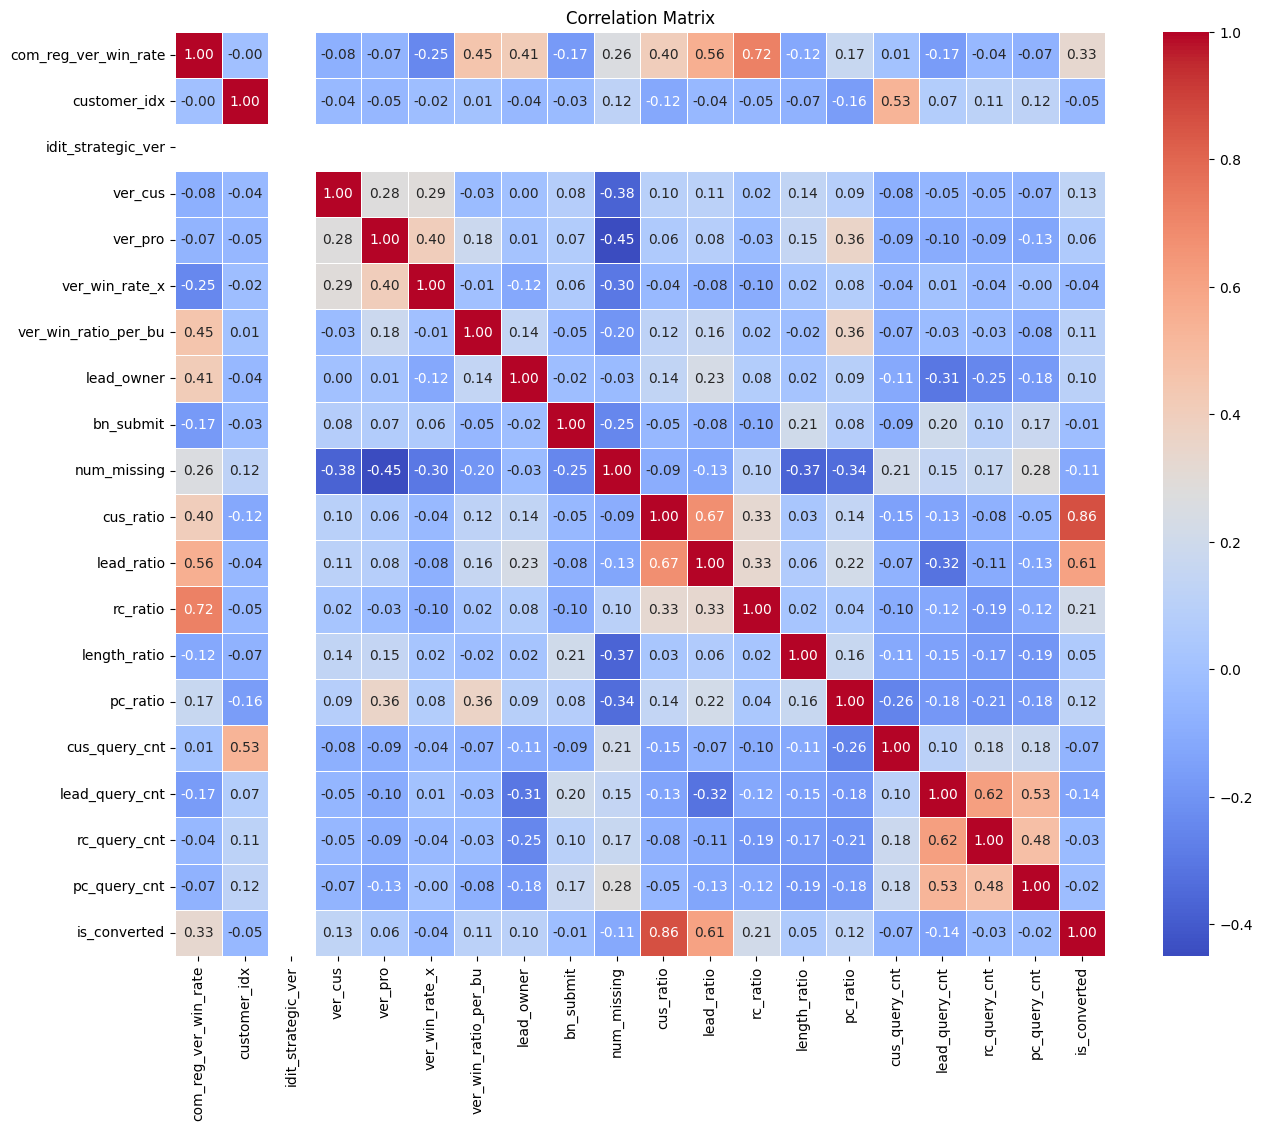

In [50]:
# 상관 관계 계산
correlation_matrix = df_train.corr()

# 상관 관계 행렬 시각화
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [51]:
df_train.columns.tolist()

['customer_country',
 'business_unit',
 'com_reg_ver_win_rate',
 'customer_idx',
 'customer_type',
 'enterprise',
 'idit_strategic_ver',
 'customer_job',
 'inquiry_type',
 'product_category',
 'customer_position',
 'response_corporate',
 'expected_timeline',
 'ver_cus',
 'ver_pro',
 'ver_win_rate_x',
 'ver_win_ratio_per_bu',
 'business_area',
 'lead_owner',
 'bn_submit',
 'num_missing',
 'product_large_category',
 'cus_ratio',
 'lead_ratio',
 'rc_ratio',
 'length_ratio',
 'pc_ratio',
 'cus_query_cnt',
 'lead_query_cnt',
 'rc_query_cnt',
 'pc_query_cnt',
 'is_converted']

In [ ]:
[ 'customer_idx',
 ver_win_rate_x
  bn_submit
  num_missing
  product_large_category

]

In [ ]:
historical_existing_cnt

## 2.4 결측치 채우기

In [ ]:
df_train = df_train.fillna(-1)
df_test = df_test.fillna(-1)

In [ ]:
df_train.isnull().sum().sum()

0

In [ ]:
df_test.drop(columns=['is_converted'], inplace=True)

KeyError: "['is_converted'] not found in axis"

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51479 entries, 0 to 51478
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_country        51479 non-null  object 
 1   business_unit           51479 non-null  object 
 2   com_reg_ver_win_rate    51479 non-null  float64
 3   customer_idx            51479 non-null  int64  
 4   customer_type           51479 non-null  object 
 5   enterprise              51479 non-null  object 
 6   idit_strategic_ver      51479 non-null  float64
 7   customer_job            51479 non-null  object 
 8   inquiry_type            51479 non-null  object 
 9   product_category        51479 non-null  object 
 10  customer_position       51479 non-null  object 
 11  response_corporate      51479 non-null  object 
 12  expected_timeline       51479 non-null  object 
 13  ver_cus                 51479 non-null  int64  
 14  ver_pro                 51479 non-null

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 51479 to 56749
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_country        5271 non-null   object 
 1   business_unit           5271 non-null   object 
 2   com_reg_ver_win_rate    5271 non-null   float64
 3   customer_idx            5271 non-null   int64  
 4   customer_type           5271 non-null   object 
 5   enterprise              5271 non-null   object 
 6   idit_strategic_ver      5271 non-null   float64
 7   customer_job            5271 non-null   object 
 8   inquiry_type            5271 non-null   object 
 9   product_category        5271 non-null   object 
 10  customer_position       5271 non-null   object 
 11  response_corporate      5271 non-null   object 
 12  expected_timeline       5271 non-null   object 
 13  ver_cus                 5271 non-null   int64  
 14  ver_pro                 5271 non-nu

## 3. LE + OV + 원복

In [ ]:
# 여기까지는 df_train이랑 df_test만 있음

### Label Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Identify object-type columns in both datasets
object_columns_train = df_train.select_dtypes(include=['object']).columns.tolist()
object_columns_test = df_test.select_dtypes(include=['object']).columns.tolist()

# Convert object columns to strings to ensure uniform data type
for column in object_columns_train:
    df_train[column] = df_train[column].astype(str)
    df_test[column] = df_test[column].astype(str)

# Initialize a dictionary to hold the LabelEncoders for each column
label_encoders = {}

# Apply Label Encoding to each object column
for column in object_columns_train:
    # Combine the training and testing data for this column, ensuring all data is treated as string
    combined_column_data = pd.concat([df_train[column], df_test[column]]).astype(str)
    le = LabelEncoder()
    le.fit(combined_column_data)  # Fit the encoder on the combined data
    # Transform both training and testing datasets
    df_train[column] = le.transform(df_train[column].astype(str))
    df_test[column] = le.transform(df_test[column].astype(str))
    # Update the dictionary of label encoders
    label_encoders[column] = le

### Over Sampling

In [ ]:
from imblearn.over_sampling import ADASYN
# Apply ADASYN
adasyn = ADASYN(random_state=69)
X_resampled, y_resampled = adasyn.fit_resample(df_train.drop('is_converted', axis=1), df_train['is_converted'])

### Reverse label encoding


In [ ]:
# Reverse label encoding
for column, le in label_encoders.items():
    if column in X_resampled.columns:  # Check if the column is in the resampled data
        X_resampled[column] = le.inverse_transform(X_resampled[column])

# Note: At this point, X_resampled contains the original categorical values for the object columns,
# and y_resampled contains the balanced target variable.

# If you want to reverse label encoding in df_test as well
for column, le in label_encoders.items():
    if column in df_test.columns:
        df_test[column] = le.inverse_transform(df_test[column])

In [ ]:
# X_resampled와 y_resampled를 하나의 DataFrame으로 결합
df_train = X_resampled.copy()
df_train['is_converted'] = y_resampled

## 4. AutoGluon

In [ ]:
train_data = df_train
submission_data = df_test

In [ ]:
import os
import pandas as pd
import random
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.core as ag

import warnings
warnings.filterwarnings("ignore")

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(69)

In [ ]:
train_data = TabularDataset(train_data)
submission_data = TabularDataset(submission_data)

label = 'is_converted'  # 레이블 이름 업데이트
eval_metric = 'f1'  # 평가 메트릭을 F1으로 설정
# time_limit = 3600 * 6  # 필요에 따라 조정

In [ ]:
predictor = TabularPredictor(
    label=label, eval_metric=eval_metric
).fit(train_data,
      presets='best_quality',
#     time_limit=time_limit,
      num_gpus=1
      )

No path specified. Models will be saved in: "AutogluonModels/ag-20240225_125038"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 3600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240225_125038/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20240225_125038/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.

In [ ]:
# is_converted 열 추가
submission_data['is_converted'] = None

In [ ]:
df_test

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,NaN
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson City / United States,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,NaN
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,NaN
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,NaN
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,/São Paulo/Brazil,AS,NaN,40292,NaN,Enterprise,10.0,NaN,...,LGESP,NaN,0,0,NaN,NaN,NaN,NaN,97,NaN
5267,7979,0.25,General / / United States,IT,NaN,47466,NaN,Enterprise,0.0,NaN,...,LGEUS,NaN,0,0,NaN,NaN,NaN,NaN,438,NaN
5268,12887,0.75,/ OURO BRANCO / Brazil,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,NaN,...,LGESP,less than 3 months,0,0,NaN,NaN,NaN,NaN,97,NaN
5269,17530,0.00,/ / Germany,IT,NaN,45667,End Customer,SMB,NaN,NaN,...,LGEDG,NaN,0,0,NaN,NaN,NaN,NaN,429,NaN


In [ ]:
submission_data

,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,idit_strategic_ver,customer_job,inquiry_type,product_category,...,lead_ratio,rc_ratio,length_ratio,pc_ratio,cus_query_cnt,lead_query_cnt,rc_query_cnt,pc_query_cnt,is_converted,id
51479,Brazil,ID,0.073248,47466,End Customer,Enterprise,-1.0,consulting,others,-1,...,0.302545,0.034442,0.00,-1.000000,6780,91,8314,-1.0,0.0,NaN
51480,United States,IT,-1.000000,5405,End Customer,SMB,-1.0,-1,quotation or purchase consultation,-1,...,0.837034,0.147368,5.75,-1.000000,2,111,5065,-1.0,1.0,NaN
51481,U.A.E,ID,-1.000000,13597,Specifier/ Influencer,SMB,-1.0,information technology,quotation or purchase consultation,hospital tv,...,-1.000000,0.026540,138.00,0.040936,0,0,1766,135.0,0.0,NaN
51482,United States,ID,0.118644,17204,-1,Enterprise,-1.0,sales,quotation or purchase consultation,-1,...,0.000984,0.147368,1.50,-1.000000,0,1991,5065,-1.0,0.0,NaN
51483,Brazil,ID,0.074949,2329,End Customer,Enterprise,1.0,engineering,quotation or purchase consultation,led signage,...,0.099949,0.034442,107.00,0.062431,0,422,8314,1677.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56745,Brazil,AS,-1.000000,40292,-1,Enterprise,-1.0,sales,quotation or purchase consultation,-1,...,0.000880,0.034442,3.50,-1.000000,3,2228,8314,-1.0,0.0,NaN
56746,United States,IT,-1.000000,47466,-1,Enterprise,-1.0,-1,quotation or purchase consultation,-1,...,0.621719,0.147368,39.25,-1.000000,6780,27,5065,-1.0,1.0,NaN
56747,Brazil,AS,-1.000000,46227,Specifier/ Influencer,Enterprise,-1.0,entrepreneurship,others,multi-split,...,0.000880,0.034442,29.25,0.026652,0,2228,8314,3266.0,0.0,NaN
56748,Germany,IT,-1.000000,45667,End Customer,SMB,-1.0,-1,others,cloud device,...,0.137151,0.042214,0.00,0.043036,0,11,850,46.0,0.0,NaN


In [ ]:
print(predictor.leaderboard(silent=True))

model_pred = predictor.predict(submission_data.drop(columns=[label]))

                      model  score_val eval_metric  pred_time_val  \
0           LightGBM_BAG_L2   0.995157          f1      73.240056   
1       WeightedEnsemble_L3   0.995157          f1      73.412452   
2    NeuralNetFastAI_BAG_L2   0.995069          f1      75.360916   
3      LightGBMLarge_BAG_L2   0.994915          f1      73.193455   
4            XGBoost_BAG_L2   0.994894          f1      73.432590   
5         LightGBMXT_BAG_L2   0.994776          f1      73.443845   
6           CatBoost_BAG_L2   0.994732          f1      73.236509   
7   RandomForestGini_BAG_L2   0.994712          f1      75.378152   
8     ExtraTreesGini_BAG_L2   0.994680          f1      75.666218   
9   RandomForestEntr_BAG_L2   0.994662          f1      75.386802   
10     CatBoost_r177_BAG_L2   0.994621          f1      73.097393   
11    ExtraTreesEntr_BAG_L2   0.994580          f1      75.423484   
12      WeightedEnsemble_L2   0.992388          f1      66.511962   
13    ExtraTreesEntr_BAG_L1   0.99

## 5. 제출하기

In [ ]:
# 최종 제출 파일 생성
submission_data[label] = model_pred
final_submission_path = '/content/drive/MyDrive/Colab Notebooks/Taeho/LGAimers/submission_DP_OS_AG.csv'
submission_data.to_csv(final_submission_path, index=False, encoding="utf-8")

final_submission_path

'/content/drive/MyDrive/Colab Notebooks/Taeho/LGAimers/submission_DP_OS_AG.csv'

In [ ]:
converted_count = submission_data['is_converted'].value_counts()

In [ ]:
converted_count

is_converted
0.0    4714
1.0     557
Name: count, dtype: int64

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Taeho/LGAimers/submission.csv') # 테스트 데이터(제출파일의 데이터)

In [ ]:
# 여기에 submission_data 가져와서

In [ ]:
# df_test의 is_converted 열에 submission_data의 is_converted 열 값을 넣어주는 코드를 만들어줘

In [ ]:
submission_data

,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,idit_strategic_ver,customer_job,inquiry_type,product_category,...,cus_ratio,lead_ratio,rc_ratio,length_ratio,pc_ratio,cus_query_cnt,lead_query_cnt,rc_query_cnt,pc_query_cnt,is_converted
51479,Brazil,ID,0.073248,47466,End Customer,Enterprise,-1.0,consulting,others,-1,...,0.008708,0.302545,0.034442,0.00,-1.000000,6780,91,8314,-1.0,0.0
51480,United States,IT,-1.000000,5405,End Customer,SMB,-1.0,-1,quotation or purchase consultation,-1,...,0.348843,0.837034,0.147368,5.75,-1.000000,2,111,5065,-1.0,1.0
51481,U.A.E,ID,-1.000000,13597,Specifier/ Influencer,SMB,-1.0,information technology,quotation or purchase consultation,hospital tv,...,-1.000000,-1.000000,0.026540,138.00,0.040936,0,0,1766,135.0,0.0
51482,United States,ID,0.118644,17204,-1,Enterprise,-1.0,sales,quotation or purchase consultation,-1,...,-1.000000,0.000984,0.147368,1.50,-1.000000,0,1991,5065,-1.0,0.0
51483,Brazil,ID,0.074949,2329,End Customer,Enterprise,1.0,engineering,quotation or purchase consultation,led signage,...,-1.000000,0.099949,0.034442,107.00,0.062431,0,422,8314,1677.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56745,Brazil,AS,-1.000000,40292,-1,Enterprise,-1.0,sales,quotation or purchase consultation,-1,...,0.011632,0.000880,0.034442,3.50,-1.000000,3,2228,8314,-1.0,0.0
56746,United States,IT,-1.000000,47466,-1,Enterprise,-1.0,-1,quotation or purchase consultation,-1,...,0.008708,0.621719,0.147368,39.25,-1.000000,6780,27,5065,-1.0,1.0
56747,Brazil,AS,-1.000000,46227,Specifier/ Influencer,Enterprise,-1.0,entrepreneurship,others,multi-split,...,-1.000000,0.000880,0.034442,29.25,0.026652,0,2228,8314,3266.0,0.0
56748,Germany,IT,-1.000000,45667,End Customer,SMB,-1.0,-1,others,cloud device,...,-1.000000,0.137151,0.042214,0.00,0.043036,0,11,850,46.0,0.0


In [ ]:
df_test['is_converted'] = submission_data['is_converted']

In [ ]:
final_submission_path = '/content/drive/MyDrive/Colab Notebooks/Taeho/LGAimers/submission_DP_OS_AG.csv'

df_test.to_csv(final_submission_path, index=False, encoding="utf-8")

In [ ]:
df_test

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,NaN
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson City / United States,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,NaN
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,NaN
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,NaN
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,/São Paulo/Brazil,AS,NaN,40292,NaN,Enterprise,10.0,NaN,...,LGESP,NaN,0,0,NaN,NaN,NaN,NaN,97,NaN
5267,7979,0.25,General / / United States,IT,NaN,47466,NaN,Enterprise,0.0,NaN,...,LGEUS,NaN,0,0,NaN,NaN,NaN,NaN,438,NaN
5268,12887,0.75,/ OURO BRANCO / Brazil,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,NaN,...,LGESP,less than 3 months,0,0,NaN,NaN,NaN,NaN,97,NaN
5269,17530,0.00,/ / Germany,IT,NaN,45667,End Customer,SMB,NaN,NaN,...,LGEDG,NaN,0,0,NaN,NaN,NaN,NaN,429,NaN


In [ ]:
submission_data

,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,idit_strategic_ver,customer_job,inquiry_type,product_category,...,cus_ratio,lead_ratio,rc_ratio,length_ratio,pc_ratio,cus_query_cnt,lead_query_cnt,rc_query_cnt,pc_query_cnt,is_converted
51479,Brazil,ID,0.073248,47466,End Customer,Enterprise,-1.0,consulting,others,-1,...,0.008708,0.302545,0.034442,0.00,-1.000000,6780,91,8314,-1.0,0.0
51480,United States,IT,-1.000000,5405,End Customer,SMB,-1.0,-1,quotation or purchase consultation,-1,...,0.348843,0.837034,0.147368,5.75,-1.000000,2,111,5065,-1.0,1.0
51481,U.A.E,ID,-1.000000,13597,Specifier/ Influencer,SMB,-1.0,information technology,quotation or purchase consultation,hospital tv,...,-1.000000,-1.000000,0.026540,138.00,0.040936,0,0,1766,135.0,0.0
51482,United States,ID,0.118644,17204,-1,Enterprise,-1.0,sales,quotation or purchase consultation,-1,...,-1.000000,0.000984,0.147368,1.50,-1.000000,0,1991,5065,-1.0,0.0
51483,Brazil,ID,0.074949,2329,End Customer,Enterprise,1.0,engineering,quotation or purchase consultation,led signage,...,-1.000000,0.099949,0.034442,107.00,0.062431,0,422,8314,1677.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56745,Brazil,AS,-1.000000,40292,-1,Enterprise,-1.0,sales,quotation or purchase consultation,-1,...,0.011632,0.000880,0.034442,3.50,-1.000000,3,2228,8314,-1.0,0.0
56746,United States,IT,-1.000000,47466,-1,Enterprise,-1.0,-1,quotation or purchase consultation,-1,...,0.008708,0.621719,0.147368,39.25,-1.000000,6780,27,5065,-1.0,1.0
56747,Brazil,AS,-1.000000,46227,Specifier/ Influencer,Enterprise,-1.0,entrepreneurship,others,multi-split,...,-1.000000,0.000880,0.034442,29.25,0.026652,0,2228,8314,3266.0,0.0
56748,Germany,IT,-1.000000,45667,End Customer,SMB,-1.0,-1,others,cloud device,...,-1.000000,0.137151,0.042214,0.00,0.043036,0,11,850,46.0,0.0


In [ ]:
submission_data['id'] = df_test['id']

In [ ]:
submission_data

,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,idit_strategic_ver,customer_job,inquiry_type,product_category,...,lead_ratio,rc_ratio,length_ratio,pc_ratio,cus_query_cnt,lead_query_cnt,rc_query_cnt,pc_query_cnt,is_converted,id
51479,Brazil,ID,0.073248,47466,End Customer,Enterprise,-1.0,consulting,others,-1,...,0.302545,0.034442,0.00,-1.000000,6780,91,8314,-1.0,0.0,NaN
51480,United States,IT,-1.000000,5405,End Customer,SMB,-1.0,-1,quotation or purchase consultation,-1,...,0.837034,0.147368,5.75,-1.000000,2,111,5065,-1.0,1.0,NaN
51481,U.A.E,ID,-1.000000,13597,Specifier/ Influencer,SMB,-1.0,information technology,quotation or purchase consultation,hospital tv,...,-1.000000,0.026540,138.00,0.040936,0,0,1766,135.0,0.0,NaN
51482,United States,ID,0.118644,17204,-1,Enterprise,-1.0,sales,quotation or purchase consultation,-1,...,0.000984,0.147368,1.50,-1.000000,0,1991,5065,-1.0,0.0,NaN
51483,Brazil,ID,0.074949,2329,End Customer,Enterprise,1.0,engineering,quotation or purchase consultation,led signage,...,0.099949,0.034442,107.00,0.062431,0,422,8314,1677.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56745,Brazil,AS,-1.000000,40292,-1,Enterprise,-1.0,sales,quotation or purchase consultation,-1,...,0.000880,0.034442,3.50,-1.000000,3,2228,8314,-1.0,0.0,NaN
56746,United States,IT,-1.000000,47466,-1,Enterprise,-1.0,-1,quotation or purchase consultation,-1,...,0.621719,0.147368,39.25,-1.000000,6780,27,5065,-1.0,1.0,NaN
56747,Brazil,AS,-1.000000,46227,Specifier/ Influencer,Enterprise,-1.0,entrepreneurship,others,multi-split,...,0.000880,0.034442,29.25,0.026652,0,2228,8314,3266.0,0.0,NaN
56748,Germany,IT,-1.000000,45667,End Customer,SMB,-1.0,-1,others,cloud device,...,0.137151,0.042214,0.00,0.043036,0,11,850,46.0,0.0,NaN


In [ ]:
df_sub = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Taeho/LGAimers/submission.csv")
df_sub["is_converted"]=model_pred
df_sub.to_csv("/content/drive/MyDrive/Colab Notebooks/Taeho/LGAimers/submission_DP_OS_AG.csv", index=False)

In [ ]:
model_pred1 = pd.DataFrame(model_pred)

In [ ]:
model_pred1.to_csv("/content/drive/MyDrive/Colab Notebooks/Taeho/LGAimers/model_pred1.csv", index=False)